# Dynamic DOM 크롤링

- https://news.naver.com/

## 프로그램 목표(기능 명세)
1. 네이버 뉴스의 리스트를 가져온다.
2. 네이버 뉴스의 내용을 가져온다.
3. 네이버 뉴스의 댓글을 가져온다.
4. 댓글을 작성한 사용자에 기반해 댓글들을 가져온다.



## 1. 네이버 뉴스의 리스트를 가져온다.


### 세부 명세
1. https://news.naver.com/ 에 접속하여 전체 카테고리를 가져온다.
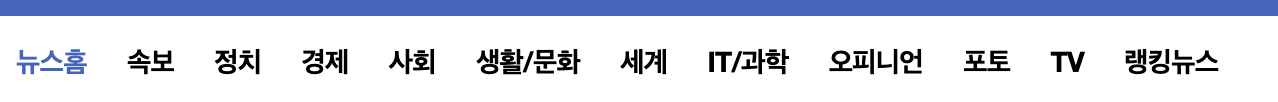

2. 카테고리마다 세부 카테고리를 가져온다.
<div style="margin:auto; text-align:center; float:left">

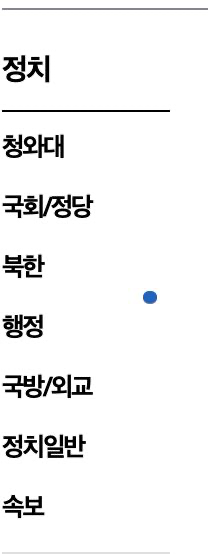
</div>

3. 세부 카테고리에 접속해 (예. 청와대) 뉴스 리스트를 가져오고 저장한다.

**위 순서대로 진행하여 전체 뉴스리스트를 가져오도록 한다.**

In [1]:
# 사용할 것들 import
import requests
import pandas as pd
from bs4 import BeautifulSoup
from urllib import parse

### 1-1. 전체 카테고리 가져오기.

#### request 보내기

In [2]:
base_url = 'https://news.naver.com/'
resp = requests.get(base_url)
if resp.status_code!=200:
    print("error발생")


#### request 분석하여 저장하기

In [3]:
parse.parse_qs?

In [4]:
def make_absolute_url(base_url, url):
    # 절대url경로로 변경
    return parse.urljoin(base_url, url)

def get_news_id(url):
    # naver는 sid1, aid 그리고 oid로 본문과 댓글에 접근한다. 그러므로 함수를 구한하여 빼내주도록 하자
    _url = parse.urlparse(url)
    qs = parse.parse_qs(_url.query)

    result_dict = {
        'sid1': None,
        'oid': None,
        'aid':None
    }
    if 'sid1' in qs:
        result_dict['sid1'] = qs.get('sid1')[0]
    
    if 'oid' in qs:
        result_dict['oid'] = qs.get('oid')[0]
    if 'aid' in qs:
        result_dict['aid'] = qs.get('aid')[0]
            
    return result_dict


In [5]:
soup = BeautifulSoup(resp.text)
cgr1_atags = soup.select('div#lnb > ul > li > a')[1:] # 카테고리1 에 대한 a태그를 CSS Selector로 select (가장 처음 나오는 카테고리(홈화면) 제거)

cgr_list = []
for cgr1_atag in cgr1_atags:
    cgr1_dict = {
        'url': make_absolute_url(base_url, cgr1_atag.get('href')), 
        'title': cgr1_atag.text.strip(),
    }
    # sid 추가
    news_id_dict = get_news_id(cgr1_dict['url'])
    cgr1_dict.update(news_id_dict)

    cgr_list.append(cgr1_dict)    


### 1-2. 카테고리마다 세부 카테고리를 가져온다.

In [6]:
import time
from urllib3.exceptions import MaxRetryError, NewConnectionError

def safe_request(url, method="GET", params=None, data=None, headers=None, n_req=3, sleep_time=10):
    """
    안전한 연결 (상태코드에 기반하여) n_req만큼 시도한다.
    req가 만약 실패시 sleep_time만큼 sleep 한다.
    """
    if method not in ['GET', 'POST', 'PUT', 'DELETE']:
        print("You should check the method argument.")
        return False
    resp = None
    for i in range(n_req):
        try:
            resp = requests.request(method=method, url=url, params=params, data=data, headers=headers)
        except MaxRetryError:
            resp = requests.request(method=method, url=url, params=params, data=data, headers=headers, verify=False)
        except NewConnectionError:
            resp = requests.request(method=method, url=url, params=params, data=data, headers=headers, verify=False)
        except:
            continue

        if (200 <= resp.status_code  < 300):
            break
        print("{}/{} 시도 실패: {}만큼 쉽니다.".format(i+1, n_req, sleep_time))
        time.sleep(sleep_time)
    return resp


In [7]:
from datetime import datetime # 날짜 시간 모듈
from tqdm import tqdm # tqdm 모듈(progress bar)

In [8]:
for cgr in tqdm(cgr_list):
    count = 0
    cgr_resp = safe_request(cgr.get('url'), method='GET')
    cgr['crawl_date'] = datetime.now().strftime("%Y/%m/%d, %H:%M:%S")

    ## 상태 업로드
    if 300 <= cgr_resp.status_code:
        # crawl 실패시 상태 업데이트
        cgr['crawl_state'] = False
        continue
    
    cgr['crawl_state'] = True

    ## 세부 카테고리 가져오기
    soup = BeautifulSoup(cgr_resp.text)
    cgr2_atags = soup.select('div.snb ul.nav > li > a')
    if not cgr2_atags:
        cgr['error_message'] = "cgr2_atag를 찾지 못함."

    # 세부리스트 만들고 추가하기
    cgr2_list = []
    for cgr2_atag in cgr2_atags:
        cgr2_dict = {
            'url': make_absolute_url(cgr.get('url'), cgr2_atag.get('href')), 
            'title': cgr2_atag.text.strip(),
        }
        # sid 추가
        news_id_dict = get_news_id(cgr2_dict['url'])
        cgr2_dict.update(news_id_dict)

        cgr2_list.append(cgr2_dict)   

    cgr['cgr2_list'] = cgr2_list


100%|██████████| 11/11 [00:01<00:00,  6.69it/s]


**1-2에서 뉴스 리스트를 DataBase에 저장한다.**  
**우리는 DataBase이라고 가정하고 DataFrame에 저장하겠다.**


In [9]:

cgr_list

[{'url': 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1=001',
  'title': '속보',
  'sid1': '001',
  'oid': None,
  'aid': None,
  'crawl_date': '2020/06/12, 21:06:27',
  'crawl_state': True,
  'cgr2_list': [{'url': 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1=100',
    'title': '정치',
    'sid1': '100',
    'oid': None,
    'aid': None},
   {'url': 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1=101',
    'title': '경제',
    'sid1': '101',
    'oid': None,
    'aid': None},
   {'url': 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1=102',
    'title': '사회',
    'sid1': '102',
    'oid': None,
    'aid': None},
   {'url': 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1=103',
    'title': '생활/문화',
    'sid1': '103',
    'oid': None,
    'aid': None},
   {'url': 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1=104',
    'title': '세계',
    'sid1': '104',
    'oid': None,
    'aid': None},
   {'url': 'https://news.naver.c

In [ ]:
# 네이버 뉴스의 내용을 가져온다.


In [10]:
def save_cgr_list(cgr_list):
    # cgr1을 DB에 저장한다.
    df = pd.DataFrame(cgr_list)

    # cgr2를 DB에 저장한다.
    cgr2_list = df['cgr2_list']
    df2 = pd.DataFrame(cgr2_list[0])
    for cgr2 in cgr2_list[1:]:
        df2 = df2.append(pd.DataFrame(cgr2))
    
    df2.reset_index(drop=True,inplace=True)

    df.drop('cgr2_list', axis=1, inplace=True)
    
    # df: cgr_list
    # df2: cgr2_list
    # 양쪽 모두 sid를 공유하기 때문에 join(merge) 이 경우 sid가 각각 PK, FK가 될 수 있음 .
    return df, df2


In [11]:
cgr_df, cgr2_df = save_cgr_list(cgr_list)


In [12]:
cgr_df.head()

,url,title,sid1,oid,aid,crawl_date,crawl_state
0,https://news.naver.com/main/list.nhn?mode=LSD&...,속보,001,None,None,"2020/06/12, 21:06:27",True
1,https://news.naver.com/main/main.nhn?mode=LSD&...,정치,100,None,None,"2020/06/12, 21:06:27",True
2,https://news.naver.com/main/main.nhn?mode=LSD&...,경제,101,None,None,"2020/06/12, 21:06:27",True
3,https://news.naver.com/main/main.nhn?mode=LSD&...,사회,102,None,None,"2020/06/12, 21:06:27",True
4,https://news.naver.com/main/main.nhn?mode=LSD&...,생활/문화,103,None,None,"2020/06/12, 21:06:27",True


In [13]:
cgr2_df.head()

,url,title,sid1,oid,aid
0,https://news.naver.com/main/list.nhn?mode=LSD&...,정치,100,None,None
1,https://news.naver.com/main/list.nhn?mode=LSD&...,경제,101,None,None
2,https://news.naver.com/main/list.nhn?mode=LSD&...,사회,102,None,None
3,https://news.naver.com/main/list.nhn?mode=LSD&...,생활/문화,103,None,None
4,https://news.naver.com/main/list.nhn?mode=LSD&...,세계,104,None,None


### 1-3. 카테고리마다 뉴스 리스트를 가져오고 저장한다.

In [14]:
# news list의 url을 분석해보자.
# https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1=001&date=20200611&page=2
# page와 date 파라미터가 눈에 띈다.
def get_news_list(cgr2, date=None, max_page=None):
    if not max_page:
        max_page = 10**10
    
    if not date:
        date = datetime.now().strftime("%Y%m%d")
    
    url = cgr2['url']
    base_url = url.split("?")[0]

    parsed = parse.urlparse(url)
    params = parse.parse_qs(parsed.query)

    # parameter설정
    page = 1
    params.update(
        {'page': 0, 'date':date}
    )
    
    # 수집
    news_list = []
    # max page 도달 전 중복이 되면 멈춘다.
    dup_count = 0
    for page in range(1, max_page+1):
        
        params.update({'page': page})

        news_list_resp = safe_request(base_url, params=params)
        soup = BeautifulSoup(news_list_resp.text)
        news_li_tags = soup.select('ul.type06_headline > li')

        

        for news in news_li_tags:
            dt_tags = news.find_all('dt')
            
            
            if len(dt_tags) == 2:
                photo = dt_tags[0].find('img').get('src')
                title = dt_tags[1].find('a').text.strip()
                url = dt_tags[1].find('a').get('href')
            elif len(dt_tags) == 1:
                photo = None
                title = dt_tags[0].find('a').text.strip()
                url = dt_tags[0].find('a').get('href')
                
            else:
                print("error: ", news_list_resp.url)
            
            news_dict = {
                'photo': photo,
                'title': title,
                'url': url,
            }
            news_dict.update(get_news_id(url))

            if news_dict in news_list:
                dup_count += 1
            else:
                news_list.append(news_dict)
            
        
        # 중복 횟수 제한
        if dup_count > 1:
            dup_count -= 0.5
        
        if dup_count > 10:
            break
    return news_list
                
            
    
    

In [15]:
news_list = []

for idx, cgr2 in tqdm(cgr2_df.iterrows()):
    news_list.extend(get_news_list(cgr2, max_page=3))
    
    # db에 중간중간 계속해서 저장합니다.
    
    # 실습을 위한 break입니다. 실제 코드에서는 제거하고 씁니다.
    if idx ==2:
        break

2it [00:01,  1.68it/s]


**=>news_list를 DB에 저장합니다. 예)newsTable**

In [16]:
def save_news_list(news_list):
    # db에 저장합니다.
    return pd.DataFrame(news_list)

In [17]:

news_df = save_news_list(news_list)

## 2. 네이버 뉴스의 내용을 가져온다.
1. 네이버 뉴스 리스트를 DB에서 가져온다.
2. 네이버 뉴스에 접속하여 본문을 가져온다.
3. 네이버 뉴스의 본문을 DB에 저장한다.

### 2-1. 네이버 뉴스 리스트를 DB에서 가져온다.

In [18]:
# db에서 가져와서 request를 합니다. 
# 여기선 가져왔다고 가정하고 news_df를 사용하겠습니다.
news_df

,photo,title,url,sid1,oid,aid
0,https://imgnews.pstatic.net/image/origin/056/2...,[뉴스9 헤드라인],https://news.naver.com/main/read.nhn?mode=LSD&...,100,056,0010851729
1,https://imgnews.pstatic.net/image/origin/437/2...,안보 위기 때 금강산 관광…'역발상'으로 위기 돌파한 DJ,https://news.naver.com/main/read.nhn?mode=LSD&...,100,437,0000240383
2,https://imgnews.pstatic.net/image/origin/056/2...,[남북의창] 끝없는 北 막말 행진…남북 관계 ‘중대 기로’,https://news.naver.com/main/read.nhn?mode=LSD&...,100,056,0010851728
3,https://imgnews.pstatic.net/image/origin/022/2...,“접경지 위험구역 지정해 봉쇄” vs “전단살포·쌀 보내기 강행”,https://news.naver.com/main/read.nhn?mode=LSD&...,100,022,0003474441
4,https://imgnews.pstatic.net/image/origin/022/2...,독립운동가단체 ‘친일파 파묘’ 현충원 행사… 보훈처 후원 논란,https://news.naver.com/main/read.nhn?mode=LSD&...,100,022,0003474440
...,...,...,...,...,...,...
85,https://imgnews.pstatic.net/image/origin/003/2...,더위 식히는 벨라루스 어린이들,https://news.naver.com/main/read.nhn?mode=LSD&...,102,003,0009912836
86,https://imgnews.pstatic.net/image/origin/421/2...,"[화보]코로나19 청정지역 청도군, ""이제부터는 경제 살리기""",https://news.naver.com/main/read.nhn?mode=LSD&...,102,421,0004693136
87,https://imgnews.pstatic.net/image/origin/449/2...,[단독]석·박사 다 빼고 조건 변경해 ‘빵집 운영자’ 선발,https://news.naver.com/main/read.nhn?mode=LSD&...,102,449,0000193172
88,https://imgnews.pstatic.net/image/origin/421/2...,이현승 완벽 피칭,https://news.naver.com/main/read.nhn?mode=LSD&...,102,421,0004693134


### 2-2. 네이버 뉴스에 접속하여 본문을 가져온다.

In [19]:
# DB에서 가져온 news_df에서 url을 찾아서 request 합니다.
# 전체 뉴스에 대해서 진행할 것이기 때문에 news_df를 반복합니다.

# 가져온 상세 페이지에 대해서 content이라고 저장합니다.
news_df.loc[:, 'content'] = None


for idx, news in news_df.iterrows():
    news_resp = safe_request(news['url'],'GET')
    if not news_resp:
        continue
    news_soup = BeautifulSoup(news_resp.text)
    content = news_soup.find('div', id='articleBody')
    news_df.loc[idx, 'content'] = content





https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=056&aid=0010851729
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<div class="vod_area"><iframe _src="/main/readVod.nhn?oid=056&amp;aid=0010851729&amp;position=1&amp;autoPlay=true&amp;viewType=" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe></div><br/><br/><b>서울 노인돌봄시설 ‘집단감염’…수도권 확산세</b><br/><br/>서울 도봉구에 있는 노인돌봄시설에서 열 명 넘게 확진자가 나오면서 고령층 집단감염 우려가 커지고 있습니다. 방문판매업체 관련 확진자도 이어지면서 수도권 확산세가 계속되고 있습니다.<br/><br/><b>‘수도권 방역 강화’ 무기한 연장…“등교 인원 제한”</b><br/><br/>정부는 14일 시한의 수도권 방역강화 조치를 무기한 연장하기로 했습니다. 교육부도 정상적인 등교가 어렵다고 보고 등교 인원 제한 조치를 이달 말까지 연장했습니다. <br/> <br/><b>‘위기 아동’ 통보했는데…‘아동 학대’ 관리는?</b><br/><br/>경남 창녕의 학대 피해 초등학생

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=056&aid=0010851728
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<div class="vod_area"><iframe _src="/main/readVod.nhn?oid=056&amp;aid=0010851728&amp;position=1&amp;autoPlay=true&amp;viewType=" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe></div><br/><br/>요즘 조선중앙TV를 보면 하루에도 몇 번씩 북한 주민들의 대남 규탄 시위 영상이 나옵니다. 대북전단을 날린 탈북민단체와 남한 정부를 향해 '불벼락'이나 '찢어죽인다' 같은 막말을 쏟아내고 있는데요. 인터뷰하는 주민이든 아나운서든 내뱉는 표현들이 갈수록 거칠어지고 있습니다. <br/> <br/>김여정 노동당 제1부부장의 담화 발표 이후 북한은 남북 간 모든 연락 채널을 중단하는 등 마치 짜인 각본대로 수순을 밟고 있는 듯한 인상을 주고 있습니다. 개성공단 완전 철거, 남북 군사합의 파기 등을 일찌감치 거론한 만큼 경고가 현실이 되지 않을까 우려가 커지고 있습니다. 전략적으로 긴장감을 고조시키는 북한의 의도 과연 무엇일까요? 영상으로 확인

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=022&aid=0003474440
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	독립운동가단체인 운암김성숙선생기념사업회가 국립대전현충원에서 진행할 ‘친일파 파묘’ 행사의 후원을 국가보훈처로부터 받았다고 주장하면서 논란이 일고 있다. 보훈처는 예산을 지원한 것은 맞지만, 애초 기념사업회가 진행하는 행사에 파묘 행사가 포함되지 않았다고 해명했다.<br/> <br/> <table align="center" border="0" class="class_div_main image" style=";text-align:center;" width="500px"><tbody><tr><td> <span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/022/2020/06/12/20200612517647_20200612210204707.jpg?type=w647"/></span> </td></tr><tr><td class="imageCaption itemCaption" style="text-align:left;word-break: break-all; word-wrap: break-word;width:500px">  친일파 묘비 모형. 운암김성숙선생기념사업회 제공.  </td></tr></tbody></table>  기념

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=119&aid=0002407851
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	[데일리안 오늘뉴스 종합]<br/><br/><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/119/2020/06/12/0002407851_001_20200612205704012.jpeg?type=w647"/><em class="img_desc">박병석 국회의장이 12일 오후 국회 상임위 구성을 위해 열린 국회 본회의에서 산회를 선포하고 있다.ⓒ데일리안 박항구 기자</em></span><strong>▲ 여당 단독 본회의 강행했으나 안건 상정 없이 산회</strong><br/><br/>더불어민주당이 12일 오후 범여권 의원들만으로 단독 본회의를 강행했으나, 본회의는 상임위원장 선출 등 안건 상정 없이 산회됐다. 미래통합당 의원들은 본회의장에 입장하지 않았다. 김성원 원내수석부대표 혼자 입장해 의사진행발언을 통해 단독 본회의와 상임위원장 선출 강행의 부당함을 역설했다. 의사진행발언 직후, 박병석 국회의장은 안건 상정 없이 산회를 선포하며 오는 15일에 본회의를 다시 열겠다고 밝혔다.<br/><br/><strong>▲ 비난 수위 높이는 북한, 정상간 합의 엎을까?</strong><br/><br/>대북전단을 구실로 

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=277&aid=0004697505
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/277/2020/06/12/0004697505_001_20200612205006039.png?type=w647"/></span><br/><br/>[아시아경제 송승윤 기자] 서울의 한 공군 부대에서 특정 병사가 특혜를 받고 있다는 의혹이 제기돼 공군이 감찰에 나섰다.<br/><br/>공군은 12일 "병사 특혜복무 의혹과 관련해 공군본부 주관으로 감찰 조사를 진행하고 있다"면서 "의혹이 제기된 부대의 상급 부대인 방공유도탄사령부 주관으로 이날 감찰에 착수했으나, 상황의 엄중함을 고려해 감찰 주관 기관을 공군본부로 상향했다"고 밝혔다.<br/><br/>이 같은 의혹은 전날 청와대 국민청원 게시판에 '금천구 공군 부대의 비위 행위를 폭로합니다'라는 제목의 청원이 올라오면서 알려졌다.<br/><br/>청원 게시자 A씨는 자신을 해당 부대에 근무 중인 부사관이라고 소개하면서 "부대에서 부모의 재력 때문에 특정 병사에게 특혜를 줬다. 이를 묵인·방조해오는 등의 비위행위를 폭로한다"고 밝혔다.<br/><br/>A씨는 해당 부대에서 부사관이 이 병사의 빨래·음료수를 배달하는 등 심

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=032&aid=0003014600
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<strong class="media_end_summary">한국 측 “관련 논의 없었다”</strong>[경향신문] <br/><br/>도널드 트럼프 미국 대통령의 측근이 한국을 포함한 해외 주둔 미군 감축 가능성을 언급했다. 한국 국방부는 “감축 관련 논의는 없었다”면서 일축했다.<br/><br/>리처드 그리넬 전 독일 주재 미국 대사는 11일(현지시간) 독일 빌트와의 인터뷰에서 “트럼프 대통령은 시리아, 아프가니스탄, 이라크, 한국, 일본, 독일에서 우리 군대를 데려오고 싶어한다”고 말했다. 지난 1일 사임한 그리넬 전 대사는 대통령 재선 캠프에 합류할 것으로 알려졌다.<br/><br/>그리넬 전 대사의 발언은 최근 논란이 된 주독 미군 감축설을 확인하는 과정에서 나온 것이다. 앞서 월스트리트저널은 지난 5일 트럼프 대통령이 최근 현재 3만4500명인 주독 미군을 2만5000명으로 줄이라고 지시했다고 보도해 파문이 일었다. 독일 정부와 백악관은 최종 결정이 내려진 것은 없다고 설명했으나 그리넬 전 대사는 “여전히 2만5000명이 남고 이는 적은 숫자가 아니다”라고 못 박았다. 그리넬 전 대사는 “미국 납세자들은 다른 국가의 방위에 많은 돈을 내는 데 지쳤다”면서 해외 주둔 미군 감축은 트럼프 대통령의

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=018&aid=0004663338
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<table align="CENTER" bgcolor="ffffff" border="0" cellpadding="0" cellspacing="5" width="500"><tr><td bgcolor="ffffff" style="PADDING-RIGHT: 2px; PADDING-LEFT: 2px; PADDING-BOTTOM: 2px; PADDING-TOP: 2px;"><table bgcolor="ffffff" border="0" cellpadding="0" cellspacing="5"><tr><td><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/018/2020/06/12/0004663338_001_20200612203602048.jpg?type=w647"/></span></td></tr><tr><td style="PADDING-BOTTOM: 0px; PADDING-LEFT: 0px; PADDING-RIGHT: 0px; FONT-FAMILY: 돋움,돋움체; COLOR: 595959; FONT-SIZE: 9pt; PADDING-TOP: 2px;"></td></tr></table></td></tr></table>[의왕=

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=032&aid=0003014598
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<strong class="media_end_summary">“예결위장 주고 법사위장 확보”<br/>여 ‘잠정 합의안’ 주장했지만<br/>야, 의총 후 “합의한 바 없다”<br/>항의 발언 1명만 본회의 입장</strong>[경향신문] <br/><br/><!--YHAP--><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/032/2020/06/12/0003014598_001_20200612203802797.jpg?type=w647"/><em class="img_desc">박병석 국회의장이 12일 국회 본회의에서 상임위원장 및 예결특위위원장 선출 안건을 상정하지 않고 산회하겠다고 밝히면서 굳은 표정을 짓고 있다. 연합뉴스</em></span><br/><!--//YHAP--><br/><br/><strong>“줄 만큼 줬다” “협상은 없다” </strong><br/><strong>여야 팽팽…접점 찾기 불투명</strong><br/><br/>21대 국회 원구성이 또다시 연기됐다. 여야 합의 실패로 국회 본회의가 열렸지만 박병석 국회의장이 상임위원장 선출을 강행하는 대신 추가 협의를 요구하면서다. 여야는 협상 시간 3일을 

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=055&aid=0000821034
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=055&amp;aid=0000821034" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	&lt;앵커&gt;<br/><br/>대북 전단 살포에 대해 정부가 강력 대응 방침을 밝힌 가운데 경기도는 아예 전단 보내는 사람들의 접경 지역 출입을 막고 위반하면 체포하겠다고 했습니다. 탈북자단체는 반발하고 있습니다.<br/><br/>먼저, 안정식 북한전문기자입니다.<br/><br/>&lt;기자&gt;<br/><br/>경기도가 전단 살포를 막기 위해 김포와 파주 등 접경 지역 일부를 위험구역으로 지정해 전단 살포자 출입을 막기로 했습니다.<br/><br/>전단 살포로 인한 북한과의 충돌 가능성을 폭발이나 붕괴 같은 사회 재난에 준하는 사태로 보고 출입을 막겠다는 것입니다.<br/><br/>[이재강/경기도 평화부지사 : 위험구역으로 설정된 지역에 경기도 특별사법경찰단을 투

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=437&aid=0000240373
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=437&amp;aid=0000240373" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<div class="jtbc_vod" id="div_NV10371317"></div><br/>[앵커]<br/><br/>2년 전 오늘(12일) 북한과 미국 두 정상은 싱가포르에서 처음으로 만나 손을 맞잡았습니다. 하지만 오늘 두 나라가 밝힌 소회는 전혀 달랐습니다. 북한은 "다시는 아무 대가 없이 미국에 치적 선전거리를 주지 않겠다"고 했고 미국은 "유연하게 접근할 의향이 있다"고 했습니다.<br/><br/>류정화 기자가 분석했습니다.<br/><br/>[기자]<br/><br/>북한 이선권 외무상이 싱가포르 정상회담 2주년을 맞아 낸 담화문입니다.<br/><br/>"다시는 아무런 대가 없이 미국 집권자에게 치적 선전감이라는 보따리를 던져주지 않을 것"이라고 했습니다.<br/><b

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=214&aid=0001044568
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=214&amp;aid=0001044568" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	[뉴스데스크]◀ 앵커 ▶<br/><br/>대기업 대표의 아들이 군 복무 중 '황제 대우'를 받고 있다는 투서가 청와대 게시판에 접수됐습니다.<br/><br/>자신의 상관에게 빨래 심부름을 시키고, 혼자서만 1인실을 사용하는 등. <br/><br/>상상하기 어려운 특혜를 받고 있다는 건데 군이 감사에 착수했습니다.  <br/><br/>이남호 기자가 취재 했습니다.<br/><br/>◀ 리포트 ▶<br/><br/>청와대 국민청원 게시판에 서울 모 공군부대의 비위행위를 폭로한다는 글이 올라왔습니다. <br/><br/>해당 부대에 근무 중인 부사관이라고 밝힌 청원인은 자신의 부대에 특혜를 받고 있는 대기업 대표 아들이 있다고 주장했습니다.<br/><br/>모 금융 관련 기업 대표의

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=001&aid=0011674957
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	올해 최대 규모 공무원 공채…17개 시도 702개 시험장서 '거리두기'<br/><br/>시험실 수용인원 20명 이하로…자가격리자 3명 별도장소 응시<br/><br/><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/001/2020/06/12/PYH2020061215600001300_P4_20200612200812497.jpg?type=w647"/><em class="img_desc">내일 공무원 시험, 방역철저(서울=연합뉴스) 한상균 기자 = 올해 최대 규모 공무원 공채 필기시험을 하루 앞둔 12일 시험장인 여의도 윤중중학교에서 방역업체 관계자들이 코로나19 방역을 하고 있다.<br/>    행정안전부와 교육부에 따르면 13일 전국 17개 시·도에서 2020년 지방공무원 및 지방교육청 공무원 8·9급 공개경쟁임용시험이 치러진다. 지방공무원은 24만531명이 593개 시험장에서, 지방교육청 공무원은 5만5천338명이 109개 시험장에서 응시 예정이다.  xyz@yna.co.kr</em></span><br/><br/>(서울=연합뉴스) 권수현 기자 = 신종 코로나바이러스 감염증(코로나19) 확산세가 이어지는 가운데

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=022&aid=0003474435
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<table align="center" border="0" class="class_div_main image" style=";text-align:center;" width="500"><tbody><tr><td> <span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/022/2020/06/12/20200612514913_20200612200203405.jpg?type=w647"/></span></td></tr></tbody></table>  “21대 국회에서 ‘저출생’으로 바꾸는 법률안이 나와 통과되길 기대합니다.”<br/> <br/>  12일 더불어민주당 최고위원회의에서 ‘저출생’이라는 낯선 용어가 등장했다. 21대 국회 원구성 완료를 위한 ‘압박성’ 발언과 정의기억연대 마포쉼터 소장 의문사 의혹 논란에 대한 당 지도부의 비판이 이어지던 중이었다.<br/> <br/>  민주당 이해찬 대표는 이날 “아무리 통합당이 관행대로 발목 잡으려 해도 21대 국회에 대한 민주당의 ‘작심’은 바뀌지 않는다”며 통합당에 ‘최후 통첩’을 했고, 김태년 원내대표는 ‘집값 안정’을 위해 “20대 국회때 처리하지 못한 종합부동세법, 소득세법,

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=018&aid=0004663330
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<table align="CENTER" bgcolor="ffffff" border="0" cellpadding="0" cellspacing="5" width="500"><tr><td bgcolor="ffffff" style="PADDING-RIGHT: 2px; PADDING-LEFT: 2px; PADDING-BOTTOM: 2px; PADDING-TOP: 2px;"><table bgcolor="ffffff" border="0" cellpadding="0" cellspacing="5"><tr><td><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/018/2020/06/12/0004663330_001_20200612195502612.jpg?type=w647"/></span></td></tr><tr><td style="PADDING-BOTTOM: 0px; PADDING-LEFT: 0px; PADDING-RIGHT: 0px; FONT-FAMILY: 돋움,돋움체; COLOR: 595959; FONT-SIZE: 9pt; PADDING-TOP: 2px;">사진=용인시</td></tr></table></td></tr></tabl

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=422&aid=0000433029
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=422&amp;aid=0000433029" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	한국과 미국, 일본 등 7개국 외교차관이 코로나19 대응을 위해 전화 협의를 했습니다.<br/><br/>외교부는 조세영 1차관을 비롯한 각국의 외교차관들이 코로나19 대응을 위한 협력 촉진 방안, 경제활동 재개 방안, 백신·치료제 개발·안정적 보급 등에 관해 의견을 교환했다고 밝혔습니다.<br/><br/>조 차관은 특히 이 자리에서 기업인 등 필수인력 이동 허용, 글로벌 가치 사슬 유지, 치료제·백신 공급과 관련한 국제사회 공조를 제안했습니다.<br/><br/>연합뉴스TV 기사문의 및 제보 : 카톡/라인 jebo23<br/><br/><a href="http://media.naver.com/channel/promotion.nhn?oid=422"> ▶ 연합뉴스TV 네이버 채널

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=022&aid=0003474439
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<table align="center" border="0" class="class_div_main image" style=";text-align:center;" width="500"><tbody><tr><td> <span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/022/2020/06/12/20200612517614_20200612210203560.jpg?type=w647"/></span></td></tr></tbody></table>  서울 양천구 목동 신시가지 6단지 아파트가 재건축 안전진단 적정성 검토를 통과했다.<br/> <br/>  목동 6단지는 12일 한국시설안전공단의 안전진단 적정성 검토에서 D등급(54.58점)을 받았다. 재건축 안전진단 분류의 경우 A∼C등급은 유지·보수(재건축 불가), D등급은 조건부 재건축(공공기관 검증 필요), E등급은 재건축 확정 판정으로 나뉜다.<br/> <br/>  앞서 목동6단지는 지난해 12월 정밀안전진단 결과 조건부 재건축에 해당하는 D등급을 받았고, 양천구청은 지난 1월 한국시설안전공단에 안전진단 적정성 검토를 의뢰한 바 있다.<br/> <br/>  1986년 지어진 

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=422&aid=0000433038
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=422&amp;aid=0000433038" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	방역당국이 롯데월드를 방문한 뒤 코로나19 확진 판정을 받았지만 이후 연이어 '음성'이 나온 고등학교 3학년 학생에 대해, '가짜 양성'이라는 최종 결론을 냈습니다.<br/><br/>정은경 중앙방역대책본부장은 오늘(12일) 정례 브리핑에서 "전문가로 구성된 진단검사관리위원회가 양성이 아닌 '위양성의 가능성이 높다는 의견을 냈다"고 밝혔습니다.<br/><br/>위양성은 본래 음성이어야 할 검사결과가 잘못돼 양성으로 나온 경우를 말합니다.<br/><br/>정 본부장은 "아직 구체적인 원인은 확인되지 않았다"며 "진단키트 문제는 아닌 것으로 판단한다"고 말했습니다.<br/><br/>연합뉴스TV 기사문의 및 제보 : 카톡/라인 jebo23<br/><br/><a href="http

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001465771
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=057&amp;aid=0001465771" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	【 앵커멘트 】<br/>  쉬운 말로 우리말로, 문화부 조일호 기자와 함께하겠습니다.<br/>  어서 오세요.<br/><br/>【 질문1 】<br/>  조 기자, 오늘 바꿀 단어는 어떤 건가요?<br/><br/>【 답변1 】<br/>  오늘 알아볼 단어, 바로 이 스마트폰과 관련있는 말입니다.<br/>  직접 제 스마트폰을 들고 나와봤는데요.<br/>  요새 스마트폰 없이 생활할 수 있는 분, 거의 없으실 겁니다.<br/>  스마트폰이 처음 나온 지 벌써 30년이 다 돼 가는데, 그 사이 세상이 걷잡을 수 없을 정도로 빠르게 변했습니다.<br/>  특히 요새는 코로나 때문에 쇼핑도 집에서 스마트폰으로 하거나, 배달 음식을 시켜먹는 시간이 부쩍 늘었는데요.<br/>  이런 

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=417&aid=0000554895
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<table align="center" border="0" cellpadding="0" cellspacing="0"><caption></caption><tr><td align="top"><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/417/2020/06/12/0000554895_001_20200612205708277.jpg?type=w647"/><em class="img_desc">여주역 금호어울림 베르티스 투시도. /사진=금호건설</em></span></td></tr></table>금호건설이 경기도 여주시 교동2지구 도시개발구역에 선보이는 ‘여주역 금호어울림 베르티스’ 견본주택을 오늘(12일) 열고 분양 일정에 들어갔다.<br/><br/>‘여주역 금호어울림 베르티스’는 여주시에 처음으로 선보이는 금호어울림 브랜드 아파트다. 단지는 지하 1층~지상 27층, 7개동 전용면적 84~136㎡, 총 605가구 규모로 조성된다. 전용면적 별로는 ▲84㎡ 578가구 ▲98㎡ 22가구 ▲136㎡ 5가구 등이다.<br/><br/>여주시는 비투기과열지구 및 비청약과열지구로 여주시에 거주하거나 경기도 및 서울시, 인천시에 거주하

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001465770
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=057&amp;aid=0001465770" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	【 앵커멘트 】<br/>  경기 군포시 등 부동산 규제를 비껴간 수도권 외곽의 주택 시장이 들썩이고 있습니다.<br/>  서울은 물론 수도권 비규제 지역까지 집값이 꿈틀대자 정부가 22번째 부동산 대책을 만지작거리고 있습니다.<br/>  정주영 기자입니다.<br/><br/>【 기자 】<br/>  경기 군포시에서 국민주택인 전용면적 84㎡ 아파트가 10억 원 턱밑까지 올랐습니다.<br/><br/> 10년 된 이 아파트는 지난 3월 석 달 만에 30% 오른 9억 원에 팔렸고, 현재 호가는 9억 5,000만 원까지 뛰었습니다.<br/><br/>  지난해 12.16 부동산 대책 이후 규제를 피하려는 뭉칫돈이 쏠렸다는 게 현장 분위기입니다.<br/><br/>▶ 인터뷰 : 경기 군포

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=417&aid=0000554893
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<table align="center" border="0" cellpadding="0" cellspacing="0"><caption></caption><tr><td align="top"><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/417/2020/06/12/0000554893_001_20200612205610707.jpg?type=w647"/><em class="img_desc">서대구역 반도유보라 센텀 투시도. /사진=반도건설</em></span></td></tr></table>반도건설은 대구 도심권 평리3동 주택재건축정비사업인 ‘서대구역 반도유보라 센텀’을 다음달 분양할 예정이라고 12일 밝혔다. <br/><br/>‘서대구역 반도유보라 센텀’은 지하 2층, 지상 23~35층, 11개동 총 1678가구의 메머드급 대단지로 희소가치가 높은 전용면적 46~84㎡의 중소형으로 구성된다. <br/><br/>‘서대구역 반도유보라 센텀’은 서대구 나들목(IC), 신천대로, 달구벌대로, 서대구로 등 풍부한 도로망으로 연결돼 대구 전역으로 빠르게 이동할 수 있고 인근에 서대구 고속철도역이 내년 개통될 예정이다.<br/><

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=057&aid=0001465765
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=057&amp;aid=0001465765" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	【 앵커멘트 】<br/>  날씨가 더워지면서 공기가 잘 통하면서 가격도 저렴한 비말 마스크 수요가 높아지고 있는데 이걸 구하기가 정말 어렵습니다. <br/>  한쪽에선 공적 마스크가 이렇게 남아도는데 말이죠. <br/>  왜 그런 건지, 해결방법은 없는지, 산업부 이혁근 기자와 짚어보겠습니다.<br/><br/>【 질문1 】<br/>  얇은 비말차단용 마스크, 주변에서 구매에 성공했다는 사람이 없다고 하네요?<br/><br/>【 기자 】<br/>  여름용 마스크가 처음 출시된 게 딱 1주일 전입니다. <br/><br/>  그날 20만 장 파는데 780만 명이 몰리면서 마스크 제조업체 홈페이지 서버가 다운되기도 했었죠.<br/><br/>  이번 주 들어서도 상황은 비슷해서 연

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=449&aid=0000193165
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=449&amp;aid=0000193165" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<div> 정부 규제로 한풀 꺾인 듯 했던 서울 집값이 강남권을 중심으로 다시 살아나고 있습니다.  <br/> <br/>늘어난 세금을 감당하지 못해 급하게 내놓았던 급매물이 정리되면서, 개발 호재 지역 중심으로 오르고 있습니다.  <br/> <br/>정부는 추가 부동산 대책을 만지작거리고 있습니다.  <br/> <br/>박지혜 기자입니다. <br/> <br/>[리포트] <br/>서울 잠실 대단지 아파트입니다.  <br/> <br/>지난 5일 서울시가 발표한 스포츠·MICE 개발사업지와 인접해 있습니다. <br/> <br/>절세 목적의 급매물이 나오면서 떨어지던 집값이 지난주 반등했습니다.  <br/> <br/>최근 거래된 전용면적 84㎡의 매매가는 16억 6천 만 원.  <br

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=449&aid=0000193163
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=449&amp;aid=0000193163" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<div> 정부로부터 받은 긴급재난지원금 아직 남아 있으신가요?  <br/> <br/>8월 31일까지 쓸 수 있지만, 이미 다 써버린 분들이 많으시던데요.  <br/> <br/>실제로 반짝 늘었던 소상공인 카드 매출이 한 달도 되지 않아 꺾였습니다.  <br/> <br/>상인들은 다시 보릿고개가 시작됐다고 합니다.  <br/> <br/>안건우 기자가 현장을 둘러봤습니다.  <br/> <br/>[리포트] <br/>[안건우 기자]  <br/>"서울 시내에서 유명한 광장시장입니다.  <br/> <br/>꼭 한 달 전에 여기에 왔는데 긴급재난지원금이 풀리기 전이었습니다.  <br/> <br/>지원금이 풀린 지난 한 달은 어땠는지, 지금은 어떨지 함께 둘러보시죠."  <br/> <br/

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=081&aid=0003098607
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	[서울신문]<br/>홈플러스의 지난해 매출액과 영업이익이 급락한 것으로 나타났다. 쇼핑의 중심이 온라인으로 바뀐데다 코로나19 위기까지 겹친 결과다.<br/><br/>홈플러스는 2019회계연도(2019년 3월~2020년 2월) 연결기준 영업이익이 전년 대비 38.4% 감소한 1602억원을 보였다고 밝혔다. 매출액은 7조3002억원으로 4.7% 줄었다.<br/><br/><!-- MobileAdNew center -->홈플러스는 “새로운 회계기준에 따라 영업비용으로 처리되던 운용리스(매장임대) 비용이 영업외비용(이자비용)으로 인식되며 영업이익 타격이 예상보다 크지 않아 보이지만 예전 기준으로 보면 영업이익은 100억원에도 미치지 못한다”고 설명했다.<br/><br/>새로운 회계기준에 따라 리스료가 부채로 설정되며 무형자산과 사용권 자산 등에 대한 손상차손 비중이 높아져 당기순손실은 5322억원으로 급증했다.<br/><br/>홈플러스는 오프라인 유통업계 불황과 코로나로 인한 매출 감소가 실적 악화에 영향을 준 것으로 보고 있다.<br/><br/>임일순 홈플러스 사장은 “오프라인 유통이 침체기이지만 홈플러스의 장점을 강화한 ‘올라인’ 사업 전략으로 위기를 정면 돌파하겠다”면서 “‘사람만큼은 안고 간다’는 

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=417&aid=0000554887
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<div></div><table align="center" border="0" cellpadding="0" cellspacing="0"><caption></caption><tr><td align="top"><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/417/2020/06/12/0000554887_001_20200612202007885.png?type=w647"/><em class="img_desc">사진=KB증권</em></span></td></tr></table><div>검찰이 KB증권 델타원솔루션부 및 리스크관리본부에 대해 압수수색을 진행했다.<br/><br/>서울남부지검 금융조사2부는 12일 오전 10시부터 오후 6시까지 KB증권 본사를 압수수색했다.<br/><br/>압수 수색과 관련해 검찰 관계자는 "구체적인 혐의 사실은 공포할 단계는 아니다"고 밝혔다. KB증권의 프라임브로커리지서비스(PBS) 사업부인 델타원솔루션부는 라임자산운용의 '환매중단 사태'와 연루돼 금융감독원의 검사를 받아온 것으로 알려졌다.</div><div><br/></div><div>앞서 금감원은 5월12일부터 6월5일까지 KB증권에 

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=056&aid=0010851679
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<div class="vod_area"><iframe _src="/main/readVod.nhn?oid=056&amp;aid=0010851679&amp;position=1&amp;autoPlay=true&amp;viewType=" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe></div><br/><br/>[KBS 청주]<br/>정부의 긴급재난지원금 효과로 늘어났던 소상공인 카드 매출이 3주 만에 다시 감소한 것으로 나타났습니다.<br/><br/>소상공인 카드 결제 정보를 관리하는 한국신용데이터는 6월 첫 주인 지난 1~7일 사이 충북 소상공인 사업장 평균 매출은 지난해 6월 첫 주(3~9일) 매출보다 3.47% 감소했다고 밝혔습니다.<br/><br/>충북지역의 경우 정부 재난 지원금이 사용이 본격화된 5월 18일부터 24일에는 2.55%, 5월 22일부터 31일에는 1.81% 증가세를 보이던 소상공인 카드 매출이 다시 감소세로 돌아선 것입니다.<br/><br/>구병회 기자 (kbh999@kbs.co.kr)<br/><br/><a href

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=008&aid=0004424212
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	[머니투데이 진경진 기자] <span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/008/2020/06/12/0004424212_001_20200612195006889.jpg?type=w647"/><em class="img_desc">영국 서부 거리 풍경./사진=AFP</em></span><br/><br/>영국의 지난 4월 국내총생산(GDP)이 코로나19(COVID-19)에 따른 경제충격으로 전월 대비 20.4% 감소했다고 영국 통계청(ONS)이 12일(현지시간) 발표했다.<br/><br/>이는 월간 기준으로 역대 최대 감소폭이며, 2008~2009년 글로벌 금융위기 당시 월별 평균 하락폭보다도 3배 이상 큰 수치다.<br/><br/>ONS는 "역사적인 추락이 사실상 모든 활동 영역에 영향을 미쳤다"며 "술집과 교육, 건강, 자동차 판매 등이 역사적인 하락에 가장 큰 역할을 했다"고 설명했다.<br/><br/>또 2월부터 4월까지 3개월 간 영국 경제가 10.4%의 마이너스 성장을 기록했다고 발표했다.<br/><br/>이는 코로나19 확산을 막기 위해 영국 정부가 락다운(봉쇄) 조치를 내린 것이 영향을 미친 것으로

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=214&aid=0001044555
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=214&amp;aid=0001044555" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	[뉴스데스크]◀ 앵커 ▶<br/><br/>코로나 19의 일부 증상이 감기와 비슷하다 보니 여름이 되면 다소 잠잠해 지지 않을까하는 기대감이 있고 관련 연구도 있습니다.<br/><br/>결론부터 보면 온도와 습도가 이 바이러스에 영향을 줄 수는 있지만 더위 피해서 바깥 대신 실내로 모여든다면 오히려 더 위험하다는 경고입니다.<br/><br/>전동혁 기자입니다.<br/><br/>◀ 리포트 ▶<br/><br/>코로나 19 확산세를 걱정스레 지켜보는 일부 전문가들의 희망 하나는 곧 장마가 오고 무더위가 온다는 겁니다.<br/><br/>코로나19 또한 2백여 종 감기 바이러스 가운데 하나인 코로나 바이러스의 변종인 만큼 더워지고 습해지면 그만큼 활동이 약해질 거라는 얘기입니다.<b

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=011&aid=0003752844
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<strong class="media_end_summary">MP그룹, 유동성 확보 위해 매각<br/>주관사 삼일회계법인 선정<br/>대주주 횡령배임 5년 연속 적자 이중고<br/>브랜드 가치 높지만 실제 매각 될지 주목</strong><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/011/2020/06/12/0003752844_001_20200612195201685.jpg?type=w647"/></span><br/>[서울경제] ‘미스터피자’로 알려진 <span stockcode="065150">MP그룹(065150)</span>이 매물로 나왔다. 대주주의 횡령·배임 혐의로 주식 거래가 정지된 이후 재무 구조까지 악화하면서 상장 폐지 위기에 몰리자 선택한 고육지책으로 풀이된다. 미스터피자 브랜드의 인지도가 높은 만큼 새 주인을 찾을 수 있을지 주목된다.<br/><br/>12일 업계에 따르면 MP그룹은 유동성 확보 및 경영 투명성 제고를 위한 매각 작업을 진행하기 위해 이사회를 열고 매각 주관사로 삼일회계법인을 선정했다. MP그룹은 인수의향서를 접수하고 적격 인수자를 우선협상대상자로 선정할 계획이다. 구체적인 일정

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=101&oid=003&aid=0009912823
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/003/2020/06/12/NISI20200212_0000477165_web_20200212193031_20200612194004709.jpg?type=w647"/><em class="img_desc">독일 프랑크푸르트 주식시장 &lt;가디언 캡쳐&gt; </em></span>[서울=뉴시스] 김재영 기자 = 미국 주식시장의 11일 폭락과 12일 아시아 시장의 내림세에 이어 개장한 유럽 주식시장이 초반 상승세를 보이고 있다.<br/><br/>AP 통신에 따르면 개장 2시간이 지난 현재 프랑스의 CAC 40은 1.2% 올랐으며 독일의 DAX도 1.1% 상승했다. 영국의 FTSE 100 역시 1.1% 올라 6146를 기록했다. <br/><br/>영국 지수는 개장 직후 국내 경제가 4월에 20.4% 축소되었다는 뉴스에 내렸으나 반등했다.<br/><br/>미 월스트리트는 선물 거래에서 다우가 2.1% 뛰어 2만5543, S&amp;P 500이 1.7% 올라 3051에 이르렀다. 본격장에서 최소한 1% 반등할 것으로 기대되고 있다.<br/><br/>전날 월스트리트는 코로나 1

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=055&aid=0000821043
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=055&amp;aid=0000821043" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<strong class="media_end_summary">임신기 근로 단축 제도 6년째, 시행 사업체 5.6%</strong>&lt;앵커&gt;<br/><br/>임신 초기와 말기 유산 위험이 높을 때 근로 시간을 줄여주는 제도가 벌써 6년째 시행되고 있습니다. 하지만 임신했다고 일 적게 하는 건 안 된다는 회사들이 여전히 많습니다. <br/><br/>제희원 기자가 취재했습니다.<br/><br/>&lt;기자&gt;<br/><br/>중소기업에서 근무하는 이 30대 여성은 올해 초 첫 아이를 임신했습니다.<br/><br/>임신 초기 매일 혼잡한 지하철을 타고 1시간을 서서 출근하면서 몸에 무리를 느꼈습니다.<br/><br/>출근 시간을 조금 늦출 수 있냐고 회사에 신청했지만 전례

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=001&aid=0011675007
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	▲ 최용덕(경주시청 퇴직) 씨 별세, 정상섭(KBS N 부장) 씨 장인상 = 12일, 경주시민장례식장 2층 국화실, 발인 14일 오전. ☎ 054-775-4443 (서울=연합뉴스)<br/><br/><span><a href="https://media.naver.com/channel/promotion.nhn?oid=001" target="_blank">▶코로나19 속보는 네이버 연합뉴스에서 [구독 클릭]</a><br/><a href="https://www.yna.co.kr/theme-list/factcheck?input=1195s" target="_blank">▶[팩트체크] 이재용 구속때 삼성주가 올랐다?</a><a href="https://www.yna.co.kr/board/jebo/index?input=offer_naver" style="margin-left:10px;" target="_blank">▶제보하기</a></span><br/><br/>
<!-- // 본문 내용 -->
</div>
<!-- [D] .guide_categorization_title 내 링크가 클릭되면 .guide_categorization_ct display:block; 해주세요 -->
<div class="guide_cat

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=448&aid=0000299716
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	[앵커]<br/>잡힐듯 잡힐듯 하면서도 코로나19가 좀처럼 잡히지 않습니다. 수도권을 중심으로 소규모 집단감염이 계속 이어지고 있어서 이러다 언제 또 감염자가 확 늘어날 지 알수없는 불안한 상황입니다. 날씨가 더워지면서 마스크 쓰는 것도 힘들지요. 불안한 정부가 당초 이번주까지로 예정했던 수도권의 강화된 생활방역 조치를 무기한 연장하기로 했습니다. 여기서 집단 감염의 고리를 끊지 못하면 무더위와 함께 사회적 거리두기로 돌아가는 최악의 상황이 올 수 있습니다. <br/><br/>최원영 기자가 먼저 보도하겠습니다.<br/><br/>[리포트]<br/>건강용품 방문판매업체인 '리치웨이' 관련 확진자는 하루 새 23명 늘어 모두 139명이 됐습니다. <br/><br/>직접 방문자보다 접촉자가 2배 이상 많은데, 교회와 사업장, 어학원, 콜센터 등 8곳 이상의 집단감염으로 이어졌습니다.<br/><br/>부천물류센터와 개척교회, 양천구 탁구장 관련 확진자도 계속 늘고 있습니다. 방역당국의 역학조사가 전파 속도를 따라가지 못하고 있는 겁니다.<br/> <br/>박능후 / 보건복지부 장관<br/>"집단감염의 연쇄고리를 끊어내지 못한다면 우리 사회는 더 큰 고통과 인내의 시간을 맞이하게 될 것입니다."<br/><br

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=081&aid=0003098610
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<strong class="media_end_summary">출범예정 산업진흥원장에 전 국장... 통합 도시관리공사 사장도 전 국장출신 하마평</strong>[서울신문]<br/><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/081/2020/06/12/0003098610_001_20200612210103474.jpg?type=w647"/><em class="img_desc">김포시청 전경</em></span>경기 김포시 공기업 및 산하 출연·출자기관 대표 등 고위직에 김포시에서 근무한 퇴직공무원들이 거의 싹쓸이하고 있는 것으로 밝혀졌다.<br/><br/>12일 김포시 등에 따르면 현재 김포시 산하 공기업 및 출자출연기관은 모두 7개다. 김포시설관리공단과 김포도시공사·청소년육성재단·문화재단·복지재단·빅데이터주식회사·시민장학재단 등이며, 오는 7월부터 출범할 산업진흥원이 있다.<br/><br/><!-- MobileAdNew center -->이 가운데 시민장학회는 김포시장이 대표로 있고, 빅데이터주식회사는 특별한 활동이 없어 청산절차가 진행 중이다. 실질적으로 운영되는 곳은 청소년육성재단과 문화재단 복지재단 등 3곳

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=003&aid=0009912846
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<strong class="media_end_summary">12일 유족, 세번째 음성유서 공개 <br/>"가해 입주민, 지속적으로 괴롭혀" <br/>"화장실로 끌고 들어가 때리기도" <br/>CCTV 확인하는 등 치밀하게 범행</strong><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/003/2020/06/12/NISI20200522_0016342934_web_20200522114559_20200612210205465.jpg?type=w647"/><em class="img_desc">[서울=뉴시스] 조수정 기자 = 서울 강북구 우이동 소재 한 아파트 경비원 폭행 혐의를 받는 입주민 심모(48)씨가 지난달 22일 오전 구속 전 피의자심문(영장실질심사)를 받은 뒤 서울 도봉동 서울북부지법을 나서 경찰 호송차량으로 향하고 있다. 2020.05.22. chocrystal@newsis.com</em></span>[서울=뉴시스] 이기상 기자 = "밥 먹으려고 하면 들어와 괴롭혔습니다. 타이밍 맞춰 들어왔습니다…화장실로 끌고 들어가 폐쇄회로(CC)TV 확인하고 모자를 벗겨 때리고…" <br/><br/>입주민에게 '갑질 

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=023&aid=0003538533
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/023/2020/06/12/2020061204035_0_20200612205502877.jpg?type=w647"/><em class="img_desc">최서원씨. /성형주 기자</em></span><br/> <span style="color:black;background:white"> </span><br/><span style="color:black;background:white">‘국정농단’ 혐의로 대법원 확정 판결을 받은 최서원(64·개명 전 최순실)씨에 대해 검찰이 벌금과 추징금 환수 작업에 나섰다.</span><br/><span style="color:black;background:white"> </span><br/><span style="color:black;background:white">서울중앙지검 집행2과는 11일 최씨에게 선고된 추징금 63억3676만원과 관련해 법원에 공탁금 출급청구를 접수했다. 벌금 200억원에 대해서도 최씨 측에 납부명령서를 보낼 예정이다.</span><br/><span style="color:black;background:w

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=449&aid=0000193177
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=449&amp;aid=0000193177" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<div> 내일 충청과 남부 지역에 계신 분들은 야외 활동을 미루시는 게 좋습니다.  <br/> <br/>주말 동안 충청이남에 집중 호우가 예상되는데요.  <br/> <br/>비는 오늘 밤 충청과 남부에서 시작돼 내일 밤 서울 등 중북부 지역으로 확대되겠습니다. <br/> <br/>충청남부와 남부 지역에 200mm 이상, 충청북부와 제주 많은 곳은 100mm 넘는 호우가 쏟아지겠고  <br/>서울 등 중북부 지역은 5~30mm가 예상됩니다.  <br/> <br/>이번 비는 일요일 낮에는 대부분 그치겠습니다.  <br/> <br/>서울 등 중북부 지역은 토요일 밤사이 주로 비가 오기 때문에 주말 바깥 활동에 차질은 없을 전망입니다.  <br/> <br/>내일 새벽부터 모레 아침 

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=056&aid=0010851727
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	서울남부지검 금융조사2부는 오늘(12일) 오전 10시부터 오후 6시까지 KB증권 델타원솔루션부와 리스크관리본부를 압수수색 했다고 밝혔습니다.<br/> <br/>검찰관계자는 "증권범죄와 관련해 압수 수색을 했다는 것만 확인해줄 수 있다"며 "혐의 사실이나 어떤 사건과 관련된 건지는 확인해 줄 수 없다"고 말했습니다. <br/> <br/>다만 일각에서는 검찰이 라임자산운용의 자금이 흘러 들어간 코스닥 상장사 에이프런티어와 관련해 KB증권을 압수 수색을 한 것 아니냐는 분석이 나오고 있습니다.<br/><br/>계현우 기자 (kye@kbs.co.kr)<br/><br/><a href="http://news.kbs.co.kr/special/coronaSpecialMain.do" target="_blank">▶ ‘코로나19 팩트체크’ 제대로 알아야 이긴다</a><br/><br/><a href="http://news.kbs.co.kr/local/main.do" target="_blank">▶ 우리 동네 무슨 일이? KBS지역뉴스</a><br/><br/><a href="https://media.naver.com/channel/promotion.nhn?oid=056" target="_blank">▶ 더 빠르고 정확한

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=277&aid=0004697508
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<strong class="media_end_summary">13일 저녁 6시 포항시청 대잠홀에서 개최</strong><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/277/2020/06/12/0004697508_001_20200612205205890.jpg?type=w647"/><em class="img_desc">쇼타임 프로젝트 공연 모습.</em></span><br/><br/>[아시아경제 영남취재본부 박동욱 기자] 사단법인 한국무용협회 경상북도지회(회장 손현)는 13일 저녁 6시 포항시청 대잠홀에서 제31회 경북무용제 겸 제29회 전국무용제지역예선대회를 개최한다.<br/><br/>이번 행사에는 경북지역의 프로·아마추어 무용인 공모전에서 1차 선발된 4개팀이 실력을 겨루게 된다. 최종 우승 팀은 한국무용협회가 주관하는 '제29회 전국무용제'에 경북대표로 참가하게 된다. <br/><br/>대회는 ▲축하공연(1개팀) ▲경연공연(4개팀) ▲특별공연(2개팀)으로 구성된다. 축하공연에서 2019년 전국무용제에서 은상을 수상한 쇼타임 프로젝트(대표 권승원)는 멈추어진 상태에서의 무기력함과 무기력함을 벗어나려는 일반인들의

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=079&aid=0003371547
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<strong class="media_end_summary">연구진실성위원회 "공저자 중 김씨 이상의 기여를 한 사람 없다"<br/>4저자 등재 포스터 "경미한 연구윤리 위반"</strong><h4>[CBS노컷뉴스 박하얀 기자]</h4><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/079/2020/06/12/0003371547_001_20200612205103590.jpg?type=w647"/><em class="img_desc">나경원 전 자유한국당 의원. (사진=윤창원 기자/자료사진)</em></span>서울대 연구진실성위원회가 나경원 전 의원의 아들 김모(24)씨가 서울대 의대 연구발표문에 제1저자로 등재된 것을 두고 "문제가 없다"는 결론을 내렸다. 김씨가 또 다른 서울대 의대 연구발표문에 제4저자로 이름을 올린 것에 대해선 '경미한 연구윤리 위반'이라고 판단했다. <br/><br/>김씨는 지난 2015년 8월 미국의 'IEEE EMBC(전기전자기술자협회 의생체공학콘퍼런스)'에서 게시된 연구 포스터 두 건에 각각 제1저자와 4저자로 이름을 올렸다. <br/><br/>김씨는 '광전용적맥파(PPG)와 심탄동

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=001&aid=0011674997
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
	
	27개 구호단체 미국에 서한…"지금이 바로 행동할 때" 호소<br/><br/>미 정부 관계자 "현재까지 10억달러 이상 지원" 반박<br/><br/><span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/001/2020/06/12/AKR20200612166800009_01_i_P4_20200612205011428.jpg?type=w647"/><em class="img_desc">마이크 폼페이오 미국 국무장관이 10일(현지시간) 기자회견 중 신종 코로나바이러스 감염증(코로나19)와 관련해 미국의 지원을 받은 국가들을 소개하는 영상을 보여주고 있다 [AFP=연합뉴스 자료사진]</em></span><br/><br/>    (서울=연합뉴스) 이재영 기자 = 세이브더칠드런과 월드비전 등 국제구호단체들이 미국의 신종 코로나바이러스 감염증(코로나19) 원조기금 집행이 지연되고 있다면서 "대단히 파괴적인 행위"라고 비판했다. <br/><br/>    AP통신은 12일(현지시간) 27개 국제구호단체가 지난 4일 미국 국제개발처(USAID)에 보낸 서한을 입수해 이같이 보도했다. <br/><br/>    구호단체들은 "지난 몇 달 

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=003&aid=0009912840
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/003/2020/06/12/NISI20200612_0016396819_web_20200612204700_20200612204810531.jpg?type=w647"/></span><br/><br/>[상트페테르부르크=AP/뉴시스]12일(현지시간) 러시아 상트페테르부르크에서 러시아 수상 비행팀 멤버들이 러시아의 날을 기념해 공연을 펼치고 있다. 1990년 6월 12일 구소련이 무너지고 러시아 연방이 설립됐다. 2020.06.12.<br/><br/><strong>[사진 영상 제보받습니다]</strong> 공감언론 뉴시스가 독자 여러분의 소중한 제보를 기다립니다. 뉴스 가치나 화제성이 있다고 판단되는 사진 또는 영상을 뉴시스 사진영상부(n-photo@newsis.com)로 보내주시면 적극 반영하겠습니다.<br/><br/>&lt;ⓒ 공감언론 뉴시스통신사. 무단전재-재배포 금지&gt;
	<!-- // 본문 내용 -->
</div>
<!-- [D] .guide_categorization_title 내 링크가 클릭되면 .guide_categorization_ct display:bl

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=003&aid=0009912838
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/003/2020/06/12/NISI20200612_0016396821_web_20200612204700_20200612204808495.jpg?type=w647"/></span><br/><br/>[상트페테르부르크=AP/뉴시스]12일(현지시간) 러시아 상트페테르부르크에서 러시아 수상 비행팀 멤버들이 러시아의 날을 기념해 하이드로 플라이트 공연을 펼치고 있다. 1990년 6월 12일 구소련이 무너지고 러시아 연방이 설립됐다. 2020.06.12.<br/><br/><strong>[사진 영상 제보받습니다]</strong> 공감언론 뉴시스가 독자 여러분의 소중한 제보를 기다립니다. 뉴스 가치나 화제성이 있다고 판단되는 사진 또는 영상을 뉴시스 사진영상부(n-photo@newsis.com)로 보내주시면 적극 반영하겠습니다.<br/><br/>&lt;ⓒ 공감언론 뉴시스통신사. 무단전재-재배포 금지&gt;
	<!-- // 본문 내용 -->
</div>
<!-- [D] .guide_categorization_title 내 링크가 클릭되면 .guide_categorization_ct 

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=003&aid=0009912836
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<span class="end_photo_org"><img alt="" src="https://imgnews.pstatic.net/image/003/2020/06/12/NISI20200612_0016396830_web_20200612204700_20200612204805282.jpg?type=w647"/></span><br/><br/>[민스크=AP/뉴시스]12일(현지시간) 벨라루스 수도 민스크의 최고 기온이 28도에 달하는 더운 날씨를 보인 가운데 분수대에서 어린이들이 더위를 식히고 있다. 2020.06.12. <br/><br/><strong>[사진 영상 제보받습니다]</strong> 공감언론 뉴시스가 독자 여러분의 소중한 제보를 기다립니다. 뉴스 가치나 화제성이 있다고 판단되는 사진 또는 영상을 뉴시스 사진영상부(n-photo@newsis.com)로 보내주시면 적극 반영하겠습니다.<br/><br/>&lt;ⓒ 공감언론 뉴시스통신사. 무단전재-재배포 금지&gt;
	<!-- // 본문 내용 -->
</div>
<!-- [D] .guide_categorization_title 내 링크가 클릭되면 .guide_categorization_ct display:block; 해주세요 -->
<div class="gui

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=102&oid=449&aid=0000193172
<div class="article_body size3 _font_setting_target" id="articleBody">
<div class="_article_body_contents" id="articleBodyContents">
<!-- 본문 내용 -->
<!-- TV플레이어 -->
<div class="vod_area">
<h4 class="blind">동영상 뉴스</h4>
<iframe _src="/main/readVod.nhn?oid=449&amp;aid=0000193172" allowfullscreen="true" frameborder="0" height="363" marginheight="0" marginwidth="0" title="영상 플레이어" width="647"></iframe>
</div>
<!-- // TV플레이어 -->
<script type="text/javascript">
// flash 오류를 우회하기 위한 함수 추가
function _flash_removeCallback() {}
</script>
<div> 서울교통 공사의 전신인 서울도시 철도공사가 관련 경험이 없는 빵집 운영자를 고위 간부로 채용해 경찰이 수사에 나섰다는 뉴스 전해드렸습니다.  <br/> <br/>알고보니 채용 요건인 석박사 학위 기준을 삭제하고 채용을 진행했습니다.  <br/> <br/>박건영 기자의 단독 보도입니다. <br/> <br/>[리포트] <br/> 서울교통공사의 전신인 서울도시철도공사는 지난 2015년, 임대사업과 광고사업을 담당할 외부 전문가를 각각 1명씩 선발할 계획을 세웠습니다.  <br/> <br/> 부장급인 3급 계약직 전문위원입니다.  <br/> <br/> 채용 공고가 처음 발표된 건 3월.  <br/> <br/> 광고 사업 분야 전문위원 1명은 채용됐습니다.  <br/> <br

https://sports.news.naver.com/news.nhn?oid=421&aid=0004693134
None
https://sports.news.naver.com/news.nhn?oid=421&aid=0004693135
None


### 2-3. 네이버 뉴스의 본문을 DB에 저장한다.

In [22]:
def save_db(news_df):
    return news_df

## 3. 네이버 뉴스의 댓글을 가져온다.


1. 네이버 뉴스의 댓글의 URL을 찾는다.
2. 네이버 뉴스URL과 댓글URL의 관계를 찾는다.
3. 댓글 URL에 대한 올바른 requests 방법을 찾는다.(header, params, cookie, body, method, url 등)
4. request를 보내고 댓글을 가져온다.

### 3-1. 네이버 뉴스의 댓글의 URL을 찾는다.

<img width="500" src="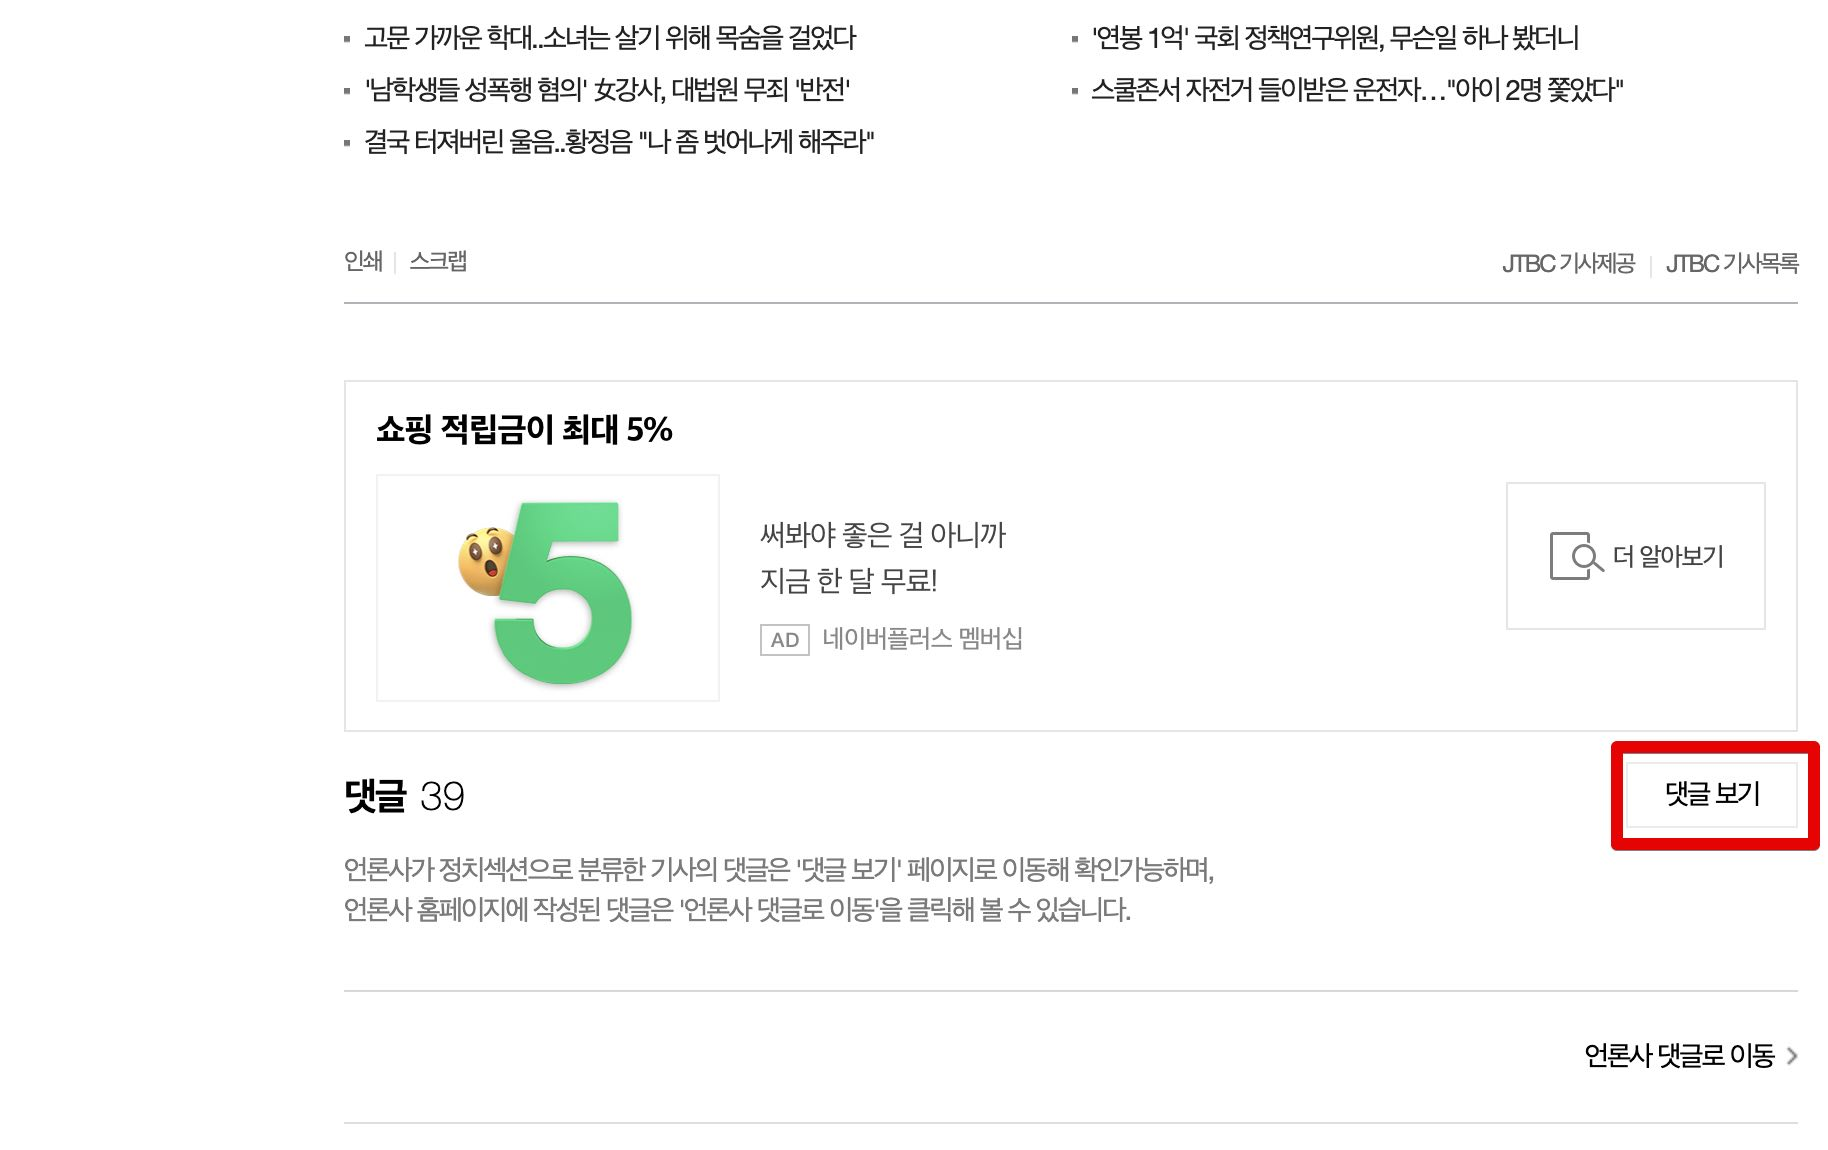
">

위 그림의 댓글보기를 클릭하자 다음과 같은 페이지가 나왔다.  
[더보기] 버튼이 있고, 이걸 클릭하니 더 많은 댓글이 나왔다.  
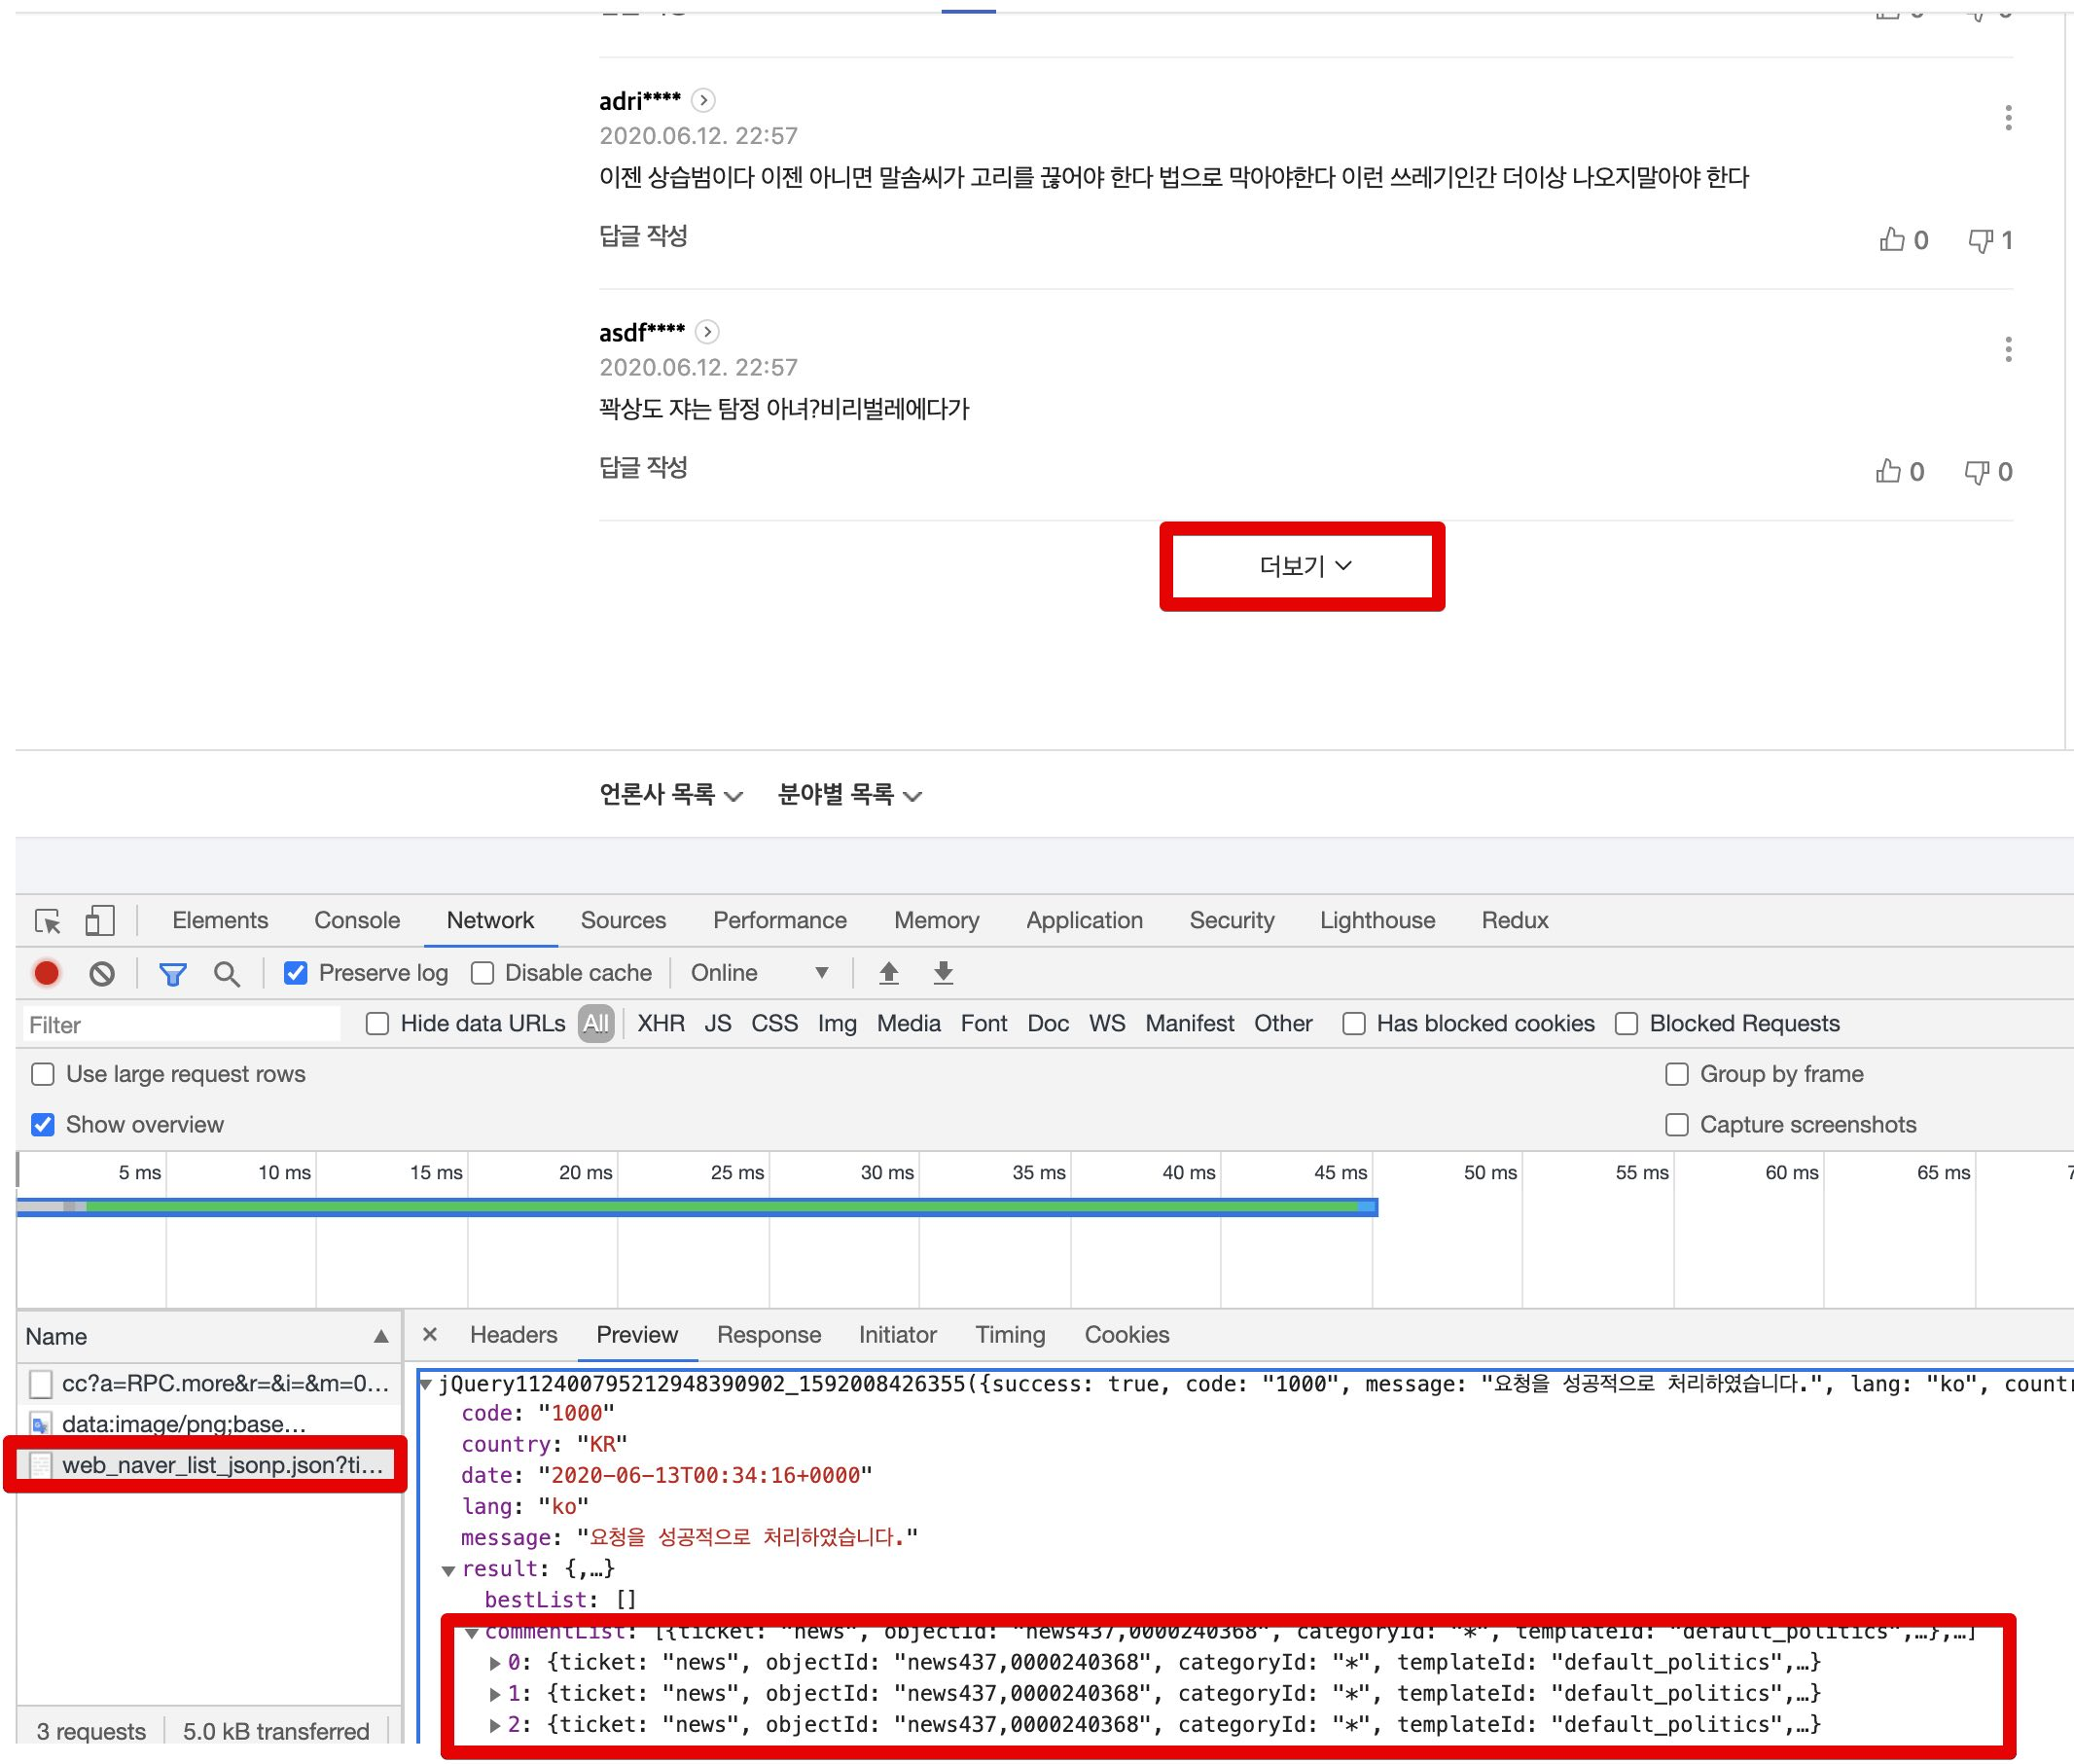


**우리는 깨달았다! 브라우저가 Ajax(비동기)요청을 한다는 것을**  
--> 다시 말해 우리가 저 댓글 버튼을 누르는 것과 동일한 요청을 보내준다면?!   
--> 댓글을 받아올 수 있다.

**해당 요청에 대한 데이터는 다음과 같았다.**
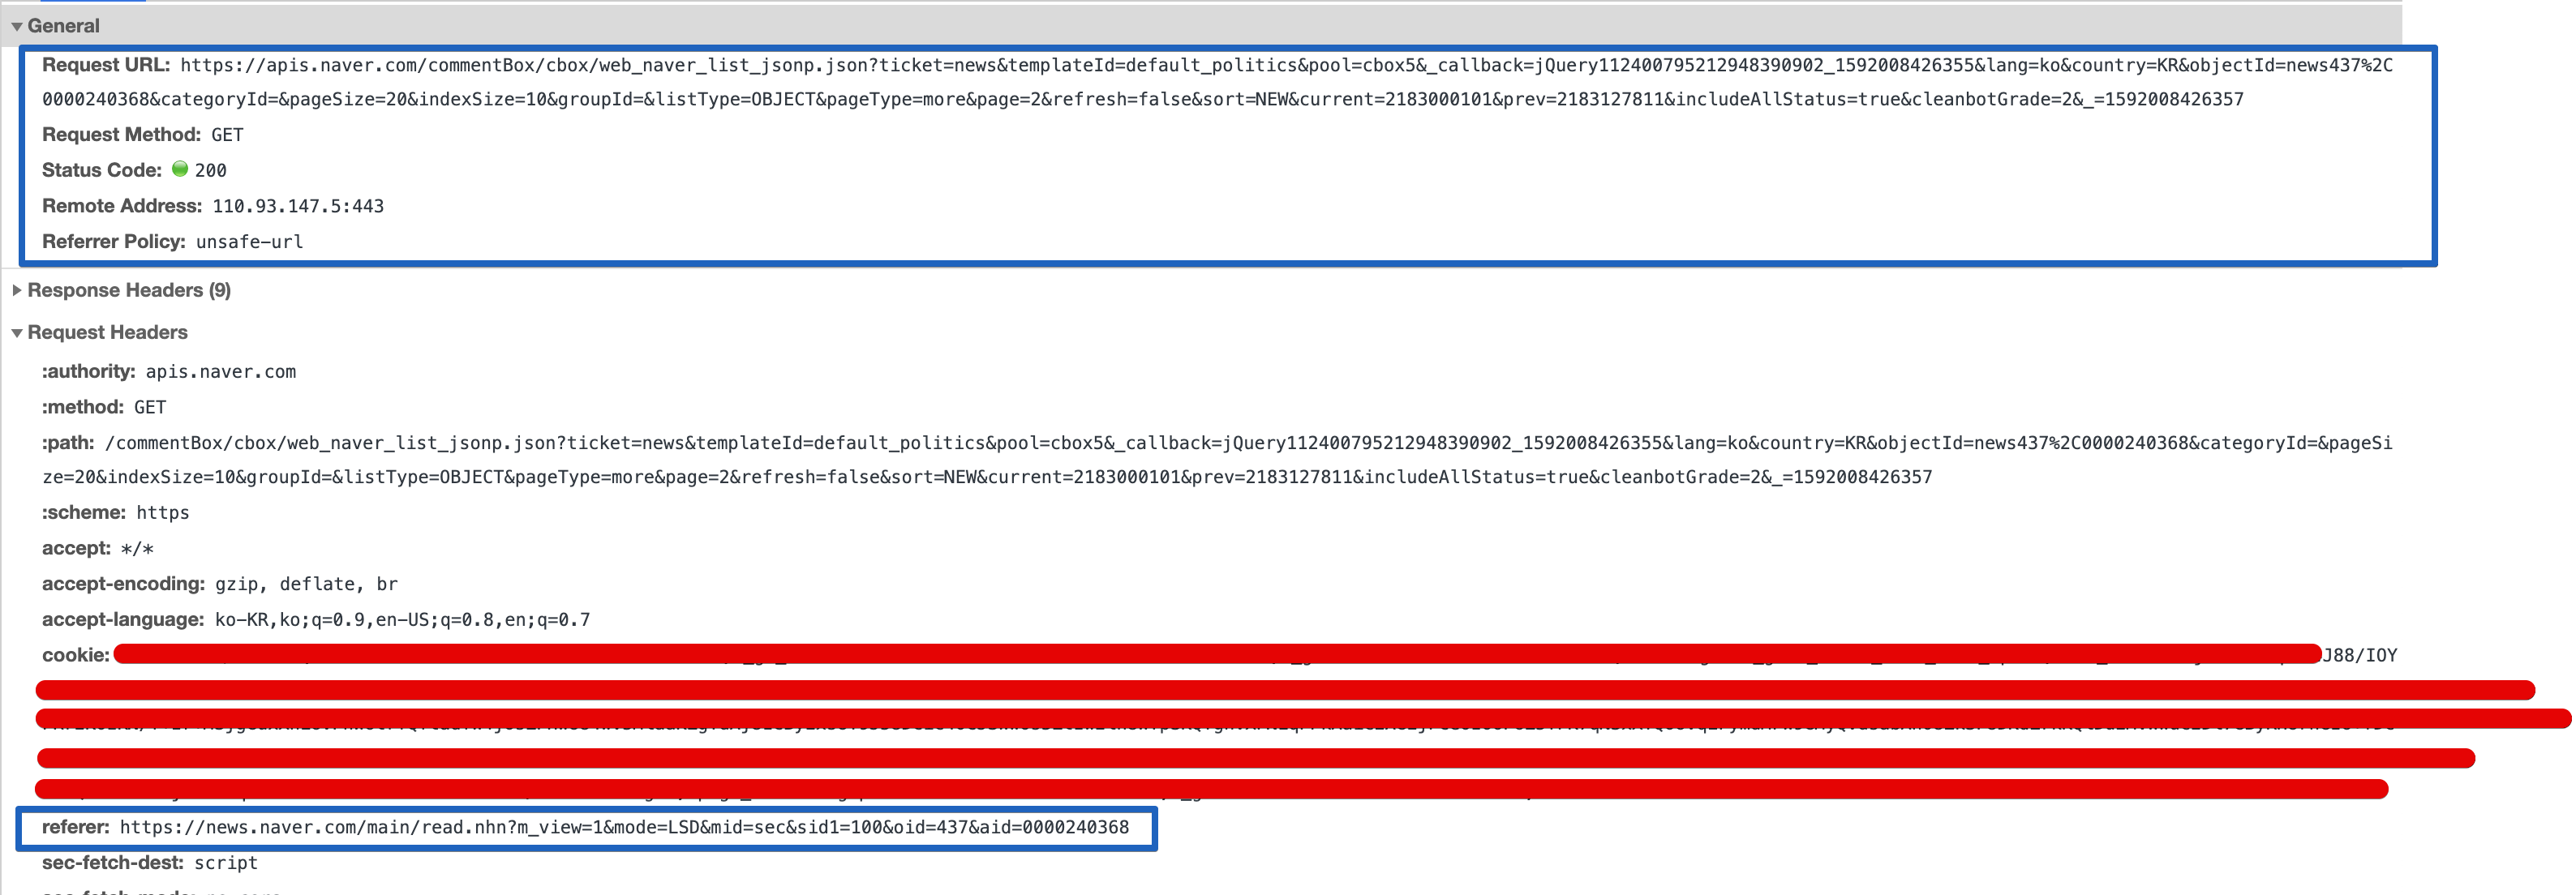

==> 우린 URL을 찾았다.!

### 3-2. 네이버 뉴스URL과 댓글URL의 관계를 찾는다.

댓글 URL은 다음과 같다.
- https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json?ticket=news&templateId=default_politics&pool=cbox5&_callback=jQuery112400795212948390902_1592008426355&lang=ko&country=KR&objectId=news437%2C0000240368&categoryId=&pageSize=20&indexSize=10&groupId=&listType=OBJECT&pageType=more&page=2&refresh=false&sort=NEW&current=2183000101&prev=2183127811&includeAllStatus=true&cleanbotGrade=2&_=1592008426357  

해당 기사에 대한 네이버 뉴스 URL은 다음과 같다.  
- https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=437&aid=0000240368

보기 편하게 parametr만 따로 분류해서 보겠다.
<div>
   <div style="float:left;">
       <h5>댓글 Params</h5>
       <img src="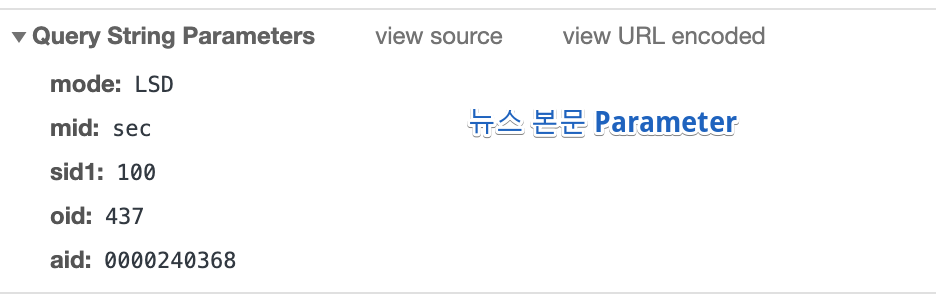
"/>
    </div>
    <div style="float:left;">
        <h5>본문 Parameter</h5>
        <img src="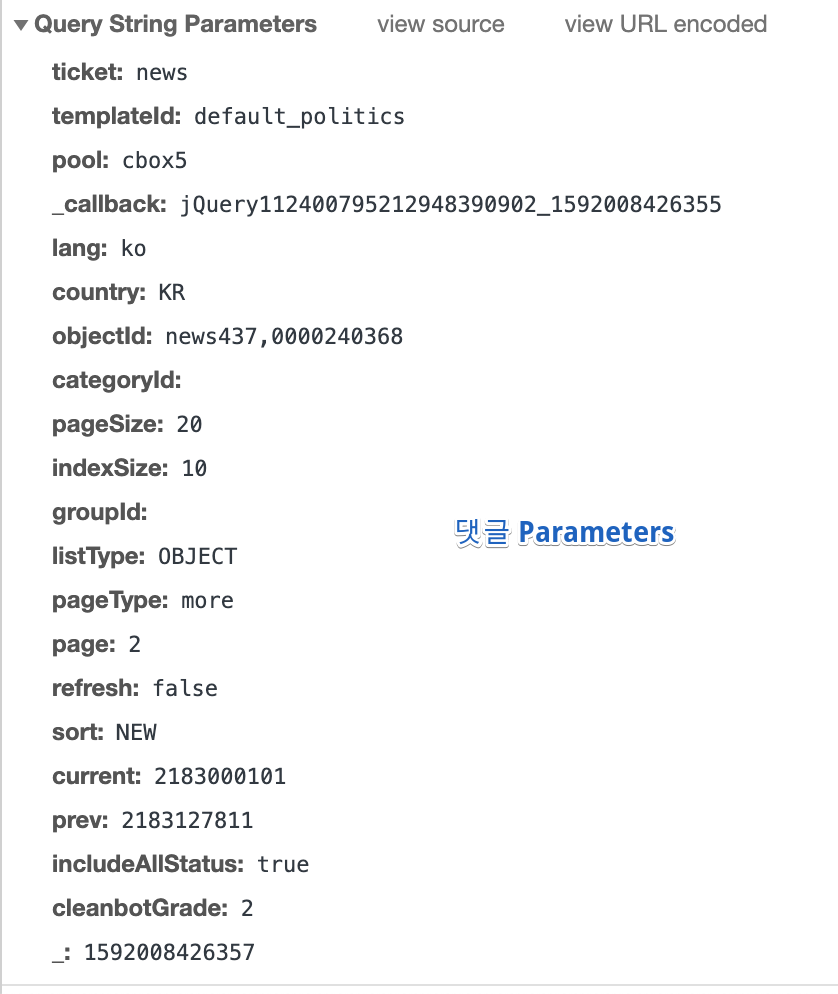
"/>
    </div>
</div>

**자세히 보면 댓글의 objectID에 news437,00002403568이 눈에 띈다.**  
- 이는 각각 원문에 oid와 aid이다. 
- ==> 관계를 찾은 것 같다.

**Tip:  만약 똑같은 request를 날렸는데 안나온다면, 모든 header와 parameter를 포함시켜서 소거하는 방법이 더 용이하다.**

### 3-3. 댓글 URL에 대한 올바른 requests 방법을 찾는다.(header, params, cookie, body, method, url 등)

올바른 requets 방법은 가장 안전하게 다 포함시키고 소거하는 방법이 더 용이하다.   
그 작업은 꽤 길어질 듯 하니 생략하겠다.  
**중요한 것은 request를 최대한 일치시키는 것!**

### 3-4. request를 보내고 댓글을 가져온다.

In [25]:
# 본문 list를 DB에서 받아와서, oid와 aid를 이용해 request를 날린다.
# 우린 이미 oid와 aid를 각각 우리의 DB에 저장했다.

news_df.head(3)

,photo,title,url,sid1,oid,aid,content
0,https://imgnews.pstatic.net/image/origin/056/2...,[뉴스9 헤드라인],https://news.naver.com/main/read.nhn?mode=LSD&...,100,056,0010851729,"[\n, [\n, 본문 내용 , \n, TV플레이어 , \n, // TV플레이..."
1,https://imgnews.pstatic.net/image/origin/437/2...,안보 위기 때 금강산 관광…'역발상'으로 위기 돌파한 DJ,https://news.naver.com/main/read.nhn?mode=LSD&...,100,437,0000240383,"[\n, [\n, 본문 내용 , \n, TV플레이어 , \n, [\n, <h4 ..."
2,https://imgnews.pstatic.net/image/origin/056/2...,[남북의창] 끝없는 北 막말 행진…남북 관계 ‘중대 기로’,https://news.naver.com/main/read.nhn?mode=LSD&...,100,056,0010851728,"[\n, [\n, 본문 내용 , \n, TV플레이어 , \n, // TV플레이..."


In [28]:
news_df[['aid', 'oid', 'url', 'sid1']].head()

,aid,oid,url,sid1
0,0010851729,056,https://news.naver.com/main/read.nhn?mode=LSD&...,100
1,0000240383,437,https://news.naver.com/main/read.nhn?mode=LSD&...,100
2,0010851728,056,https://news.naver.com/main/read.nhn?mode=LSD&...,100
3,0003474441,022,https://news.naver.com/main/read.nhn?mode=LSD&...,100
4,0003474440,022,https://news.naver.com/main/read.nhn?mode=LSD&...,100


In [85]:
# news 댓글 url을 찾았고 이에 request를 보낸다. 반복해서
comment_base_url = 'https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json' # network에서 확인한 댓글의 실제 url

# 댓글 보기를 요청한 url (댓글 더보기를 클릭한 페이지)
referal_base_url = "https://news.naver.com/main/read.nhn?m_view=1&mode=LSD&mid=sec&sid1={sid1}&oid={oid}&aid={aid}"

# comment를 저장할 리스트
my_comment_list = []
comment_default_params = {
    'ticket': 'news',
    # 'templateId': 'default_politics',
    # '_callback':'',
    'pool': 'cbox5',
    'lang': 'ko',
    'country': 'KR',
    'pageSize': 1000,
    # 'indexSize': 10,
    #'categoryId': '',

    # 'listType': 'OBJECT',
    # 'pageType': 'more',
    'page': 1,
    'sort': 'NEW',
    'includeAllStatus': 'true',
    'cleanbotGrade': 2,
    'objectId': None,
    # 'refresh': 'false',
}

# 우린 header를 소거법을 이용해 찾았다고 가정한다.
comment_default_headers = {
    # 댓글 보기를 요청한 url (댓글 더보기를 클릭한 페이지)
    'referer': None,
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'
}

for idx, news in news_df.iterrows():
    # comment request에 aid와 oid, sid1이 필요하니 빼온다.
    sid1 = news['sid1']
    aid = news['aid']
    oid = news['oid']
    
    ## url과 param과 header를 만든다.
    # header만들기
    referal_url = referal_base_url.format(sid1=sid1, oid=oid, aid=aid) # referal 만들기 (문자열을 확인하자 format함수)
    comment_headers = comment_default_headers.copy()
    comment_headers.update({'referer': referal_url})
    
    # param 만들기
    comment_params = comment_default_params.copy()
    comment_params.update({'objectId': 'news{oid},{aid}'.format(oid=oid, aid=aid)})
    
    # 요청 보내기
    comment_resp = safe_request(comment_base_url, 'GET', params=comment_params, headers=comment_headers)
    
    # 응답을 확인하기 위한 break
    break

https://news.naver.com/main/read.nhn?mode=LSD&mid=sec&sid1=100&oid=056&aid=0010851729


##### comment_resp에 대한 응답을 확인하자!

In [86]:
comment_resp.text

'_callback({"success":true,"code":"1000","message":"요청을 성공적으로 처리하였습니다.","lang":"ko","country":"KR","result":{"commentList":[],"pageModel":{"page":1,"pageSize":100,"indexSize":10,"startRow":1,"endRow":100,"totalRows":0,"startIndex":0,"totalPages":1,"firstPage":1,"prevPage":0,"nextPage":0,"lastPage":1,"current":null,"threshold":null,"moveToLastPage":false,"moveToComment":false,"moveToLastPrev":false},"exposureConfig":{"reason":null,"status":"COMMENT_ON"},"count":{"comment":0,"reply":0,"exposeCount":0,"delCommentByUser":0,"delCommentByMon":0,"blindCommentByUser":0,"blindReplyByUser":0,"total":0},"listStatus":"all","sort":"NEW","bestList":[]},"date":"2020-06-13T01:23:29+0000"});'

In [83]:
# comment_resp를 확인하자!

# 아래를 확인하면 이상한 값이 섞여 있다. 이를테면
# _callback( ); ..
# 이건 json 모듈이 아니므로, 삭제해주도록 한다.
import json
def naver_comment_resp_to_dict(naver_comment_resp_text):
    naver_comment_resp_text = naver_comment_resp_text[10:-2]
    return json.loads(naver_comment_resp_text)
    

#### 실행 파일! (댓글 가져오기)

In [96]:
# news 댓글 url을 찾았고 이에 request를 보낸다. 반복해서
comment_base_url = 'https://apis.naver.com/commentBox/cbox/web_naver_list_jsonp.json' # network에서 확인한 댓글의 실제 url

# 댓글 보기를 요청한 url (댓글 더보기를 클릭한 페이지)
referal_base_url = "https://news.naver.com/main/read.nhn?m_view=1&mode=LSD&mid=sec&sid1={sid1}&oid={oid}&aid={aid}"

# comment를 저장할 리스트
my_comment_list = []
comment_default_params = {
    'ticket': 'news',
    # 'templateId': 'default_politics',
    # '_callback':'',
    'pool': 'cbox5',
    'lang': 'ko',
    'country': 'KR',
    'pageSize': 1000,
    # 'indexSize': 10,
    #'categoryId': '',

    # 'listType': 'OBJECT',
    # 'pageType': 'more',
    'page': 1,
    'sort': 'NEW',
    'includeAllStatus': 'true',
    'cleanbotGrade': 2,
    'objectId': None,
    # 'refresh': 'false',
}

# 우린 header를 소거법을 이용해 찾았다고 가정한다.
comment_default_headers = {
    # 댓글 보기를 요청한 url (댓글 더보기를 클릭한 페이지)
    'referer': None,
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'
}

for idx, news in news_df.iterrows():
    # comment request에 aid와 oid, sid1이 필요하니 빼온다.
    sid1 = news['sid1']
    aid = news['aid']
    oid = news['oid']
    
    ## url과 param과 header를 만든다.
    # header만들기
    referal_url = referal_base_url.format(sid1=sid1, oid=oid, aid=aid) # referal 만들기 (문자열을 확인하자 format함수)
    comment_headers = comment_default_headers.copy()
    comment_headers.update({'referer': referal_url})
    
    # param 만들기
    comment_params = comment_default_params.copy()
    comment_params.update({'objectId': 'news{oid},{aid}'.format(oid=oid, aid=aid)})
    
    # 요청 보내기
    comment_resp = safe_request(comment_base_url, 'GET', params=comment_params, headers=comment_headers)
    comment_list_dict = naver_comment_resp_to_dict(comment_resp.text)
    
    # 전체 코멘트리스트를 저장하고 oid, sid1, aid 등도 함게 저장한다.
    resp_comment_list = comment_list_dict.get('result').get('commentList')
    
    for resp_comment in resp_comment_list:
        resp_comment.update({'oid':oid, 'aid':aid, 'sid1': sid1})
    my_comment_list.extend(resp_comment_list)
    
    
    # 응답을 확인하기 위한 break


In [99]:
my_comment_list[0]

{'ticket': 'news',
 'objectId': 'news437,0000240383',
 'categoryId': '*',
 'templateId': 'default_politics',
 'commentNo': 2151601552,
 'parentCommentNo': 2151601552,
 'replyLevel': 1,
 'replyCount': 0,
 'replyAllCount': 0,
 'replyPreviewNo': None,
 'replyList': None,
 'imageCount': 0,
 'imageList': None,
 'imagePathList': None,
 'imageWidthList': None,
 'imageHeightList': None,
 'commentType': 'txt',
 'stickerId': None,
 'sticker': None,
 'sortValue': 1592011582887,
 'contents': '김대중이 뭐한거 있냐? 생각이란걸 하고 기사 싸질러라. \n그래서 문재인도 뭐로 돌파하라는 의미로 기사 쓴건지 모르겠지만 문재인은 북한에서도 버린 카드다.',
 'userIdNo': '95Cta',
 'exposedUserIp': None,
 'lang': 'ko',
 'country': 'KR',
 'idType': 'naver',
 'idProvider': 'naver',
 'userName': 'hsh9****',
 'userProfileImage': '',
 'profileType': 'naver',
 'modTime': '2020-06-13T10:26:22+0900',
 'modTimeGmt': '2020-06-13T01:26:22+0000',
 'regTime': '2020-06-13T10:26:22+0900',
 'regTimeGmt': '2020-06-13T01:26:22+0000',
 'sympathyCount': 0,
 'antipathyCount': 0,
 'userBlind': Fals

In [104]:
# commnet_list를 저장한다!
def save_comment_list(comment_list):
    # 마찬가지로 저장했다고 가정하고 df화
    comment_df = pd.DataFrame(comment_list)
    return comment_df
comment_df = save_comment_list(my_comment_list)

In [106]:
comment_df.head()

,ticket,objectId,categoryId,templateId,commentNo,parentCommentNo,replyLevel,replyCount,replyAllCount,replyPreviewNo,...,blind,profileUserId,userBlocked,exposeByCountry,maskedUserId,maskedUserName,validateBanWords,oid,aid,sid1
0,news,"news437,0000240383",*,default_politics,2151601552,2151601552,1,0,0,None,...,False,None,False,False,hsh9****,hs****,False,437,0000240383,100
1,news,"news437,0000240383",*,default_politics,2151518572,2151518572,1,0,0,None,...,False,None,False,False,eric****,er****,False,437,0000240383,100
2,news,"news437,0000240383",*,default_politics,2151511062,2151511062,1,0,0,None,...,False,None,False,False,achi****,ac****,False,437,0000240383,100
3,news,"news437,0000240383",*,default_politics,2151503862,2151503862,1,0,0,None,...,False,None,False,False,rhdu****,rh****,False,437,0000240383,100
4,news,"news437,0000240383",*,default_politics,2151501162,2151501162,1,0,0,None,...,False,None,False,False,chon****,ch****,False,437,0000240383,100


## 4. 댓글을 작성한 사용자에 기반해 댓글들을 가져온다.

- 근본적인 방법은 3과 같다.  



1. 댓글을 작성한 유저의 [댓글 리스트 URL]을 찾는다.
2. 유저의 [댓글 리스트 URL]과 댓글URL의  관계를 찾는다.
3. 유저의 [댓글 리스트 URL]에 대한 올바른 requests 방법을 찾는다.(header, params, cookie, body, method, url 등)
4. request를 보내고 유저의 댓글 리스트를 가져온다.

----